### Import Libraries

In [1]:
# !pip uninstall gym
!pip install gym==0.25.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 734.5/734.5 kB 16.2 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for gym: filename=gym-0.25.2-py3-none-any.whl size=852295 sha256=c403124b6a454b835a9434323482b2dd5a736f6b3972a04a355d661f24e75a87
  Stored in directory: /root/.cache/pip/wheels/78/95/2c/ee47a8d43fda6a851e340e77e27cf75b49ff4ce2d1540c0e80
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.26.2
    Uninstalling gym-0.26.2:
      Successfully uninstalled gym-0.26.2


In [2]:
import gym
import time
import warnings
import itertools
import numpy as np
from tabulate import tabulate
import matplotlib.font_manager
import matplotlib.pyplot as plt
from collections import defaultdict

In [3]:
# Ignore warnings
warnings.filterwarnings("ignore")

### Functions

In [4]:
def pi_star_from_Q(Q, env):
    done = False
    pi_star = np.zeros([env.observation_space.n, env.action_space.n])
    state = env.reset()
    while not done:
        action = np.argmax(Q[state, :])
        pi_star[state,action] = int(1)
        state, reward, done, _ = env.step(action)
    return pi_star

In [5]:
def display_policies_with_matrices(policies, algorithm_names):
    formatted_policies = []
    for policy in policies:
        policy_rows = [str(row.astype(int).tolist()) for i, row in enumerate(policy)]
        formatted_policies.append("\n".join(policy_rows))
    table = [algorithm_names, formatted_policies]
    
    print(tabulate(table, headers="firstrow", tablefmt="grid"))

In [6]:
def get_policy_from_Q(Q, env):
    pi_star = np.zeros([env.observation_space.n, env.action_space.n])
    for s in range(env.observation_space.n):
        q = Q[s,:]


        # deterministic policy, will always choose an action
        # pi_star[s][np.argmax(q)] = 1

        # stochastic policy
        best_a = np.argwhere(q==np.max(Q[s,:])).flatten()
        pi_star[s] = np.sum([np.eye(env.action_space.n)[i] for i in best_a], axis=0)/len(best_a)
    return pi_star

In [7]:
def random_epsilon_greedy_policy(Q, epsilon, state, nA):
    A = np.ones(nA, dtype=float) * epsilon / nA
    best_action = np.argmax(Q[state])
    A[best_action] += (1.0 - epsilon)
    return A

In [8]:
def moving_average(a, n=100):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [9]:
def plot_policy_comparison(Vs, policies, env, col_ramp=1, dpi=175, draw_vals=False, titles=None):
    
    num_algorithms = len(Vs)
    plt.rcParams['figure.dpi'] = dpi
    plt.rcParams.update({'axes.edgecolor': (0.32, 0.36, 0.38)})
    plt.rcParams.update({'font.size': 4 if env.env.nrow == 8 else 7})
    
    fig, axes = plt.subplots(1, num_algorithms, figsize=(3 * num_algorithms, 3))
    
    if titles is None:
        titles = [f"Algorithm {i+1}" for i in range(num_algorithms)]
    
    for idx, (V, policy, title) in enumerate(zip(Vs, policies, titles)):
        ax = axes[idx]
        ax.imshow(1 - V.reshape(env.env.nrow, env.env.ncol)**col_ramp, cmap='gray', interpolation='none', clim=(0, 1))
        ax.set_title(title, fontsize=8)
        ax.set_xticks(np.arange(env.env.ncol) - 0.5)
        ax.set_yticks(np.arange(env.env.nrow) - 0.5)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
        for s in range(env.observation_space.n):
            x = s % env.env.nrow
            y = int(s / env.env.ncol)
            a = policy[s]
            gray = np.array((0.32, 0.36, 0.38))
            
            if env.desc.tolist()[y][x] == b'G':
                ax.text(x - 0.45, y - 0.3, 'goal', color=(0.75, 0.22, 0.17), fontname='Sans', weight='bold')
                continue
            
            if a[0] > 0.0: ax.arrow(x, y, float(a[0]) * -0.84, 0.0, color=gray + 0.2 * (1 - V[s]), head_width=0.1, head_length=0.1)
            if a[1] > 0.0: ax.arrow(x, y, 0.0, float(a[1]) * 0.84, color=gray + 0.2 * (1 - V[s]), head_width=0.1, head_length=0.1)
            if a[2] > 0.0: ax.arrow(x, y, float(a[2]) * 0.84, 0.0, color=gray + 0.2 * (1 - V[s]), head_width=0.1, head_length=0.1)
            if a[3] > 0.0: ax.arrow(x, y, 0.0, float(a[3]) * -0.84, color=gray + 0.2 * (1 - V[s]), head_width=0.1, head_length=0.1)
            
            if env.desc.tolist()[y][x] == b'F':
                ax.text(x - 0.45, y - 0.3, 'ice', color=(gray * V[s]), fontname='Sans')
            if env.desc.tolist()[y][x] == b'S':
                ax.text(x - 0.45, y - 0.3, 'start', color=(0.21, 0.51, 0.48), fontname='Sans', weight='bold')
            
            if draw_vals and V[s] > 0:
                vstr = '{0:.1e}'.format(V[s]) if env.env.nrow == 8 else '{0:.6f}'.format(V[s])
                ax.text(x - 0.45, y + 0.45, vstr, color=(gray * V[s]), fontname='Sans')
        
        ax.grid(color=(0.42, 0.46, 0.48), linestyle=':')
        ax.set_axisbelow(True)
        ax.tick_params(color=(0.42, 0.46, 0.48), which='both', top=False, left=False, right=False, bottom=False)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_experiment(name, slippery, gamma, num_episodes=10000, alpha=0.2, max_epsilon=0.4, use_epsilon_decay=False):
    env = gym.make(name, is_slippery=slippery)
    env.seed(42)
    env.action_space.seed(42)
   
    # Run different learning algorithms
    sarsa_Q, sarsa_rewards, sarsa_lengths, _, sarsa_score_history = sarsa(env, gamma=gamma, num_episodes=num_episodes, alpha=alpha, max_epsilon=max_epsilon, use_epsilon_decay=use_epsilon_decay)
    n_step_sarsa_Q, n_step_sarsa_rewards, n_step_sarsa_lengths, _, n_step_sarsa_score_history = n_step_sarsa(env, gamma=gamma, num_episodes=num_episodes, alpha=alpha, max_epsilon=max_epsilon, use_epsilon_decay=use_epsilon_decay)
    q_learning_Q, q_learning_rewards, q_learning_lengths, _, q_learning_score_history = q_learning(env, gamma=gamma, num_episodes=num_episodes, max_epsilon=max_epsilon, use_epsilon_decay=use_epsilon_decay)
    
    plt.rcParams['figure.dpi'] = 150
   
    # Convert rewards and lengths to numpy arrays
    sarsa_rewards_array = np.array(list(sarsa_rewards.values()))
    n_step_sarsa_rewards_array = np.array(list(n_step_sarsa_rewards.values()))
    q_learning_rewards_array = np.array(list(q_learning_rewards.values()))
   
    sarsa_lengths_array = np.array(list(sarsa_lengths.values()))
    n_step_sarsa_lengths_array = np.array(list(n_step_sarsa_lengths.values()))
    q_learning_lengths_array = np.array(list(q_learning_lengths.values()))
   
    # Smooth the data
    smoothed_sarsa_rewards = moving_average(sarsa_rewards_array)
    smoothed_n_step_sarsa_rewards = moving_average(n_step_sarsa_rewards_array)
    smoothed_q_learning_rewards = moving_average(q_learning_rewards_array)
   
    smoothed_sarsa_lengths = moving_average(sarsa_lengths_array)
    smoothed_n_step_sarsa_lengths = moving_average(n_step_sarsa_lengths_array)
    smoothed_q_learning_lengths = moving_average(q_learning_lengths_array)
   
    # Create a figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
    
    # Rewards plot
    ax1.plot(smoothed_sarsa_rewards, label='SARSA', color='#008080')  # Xanh lam
    ax1.plot(smoothed_n_step_sarsa_rewards, label='N-Step SARSA', color='#CC6600')  # Cam
    ax1.plot(smoothed_q_learning_rewards, label='Q-Learning', color='#009933')  # Xanh lá cây
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward (Smoothed)')
    ax1.legend()
    ax1.set_title('Smoothed Rewards')

    # Episode Lengths plot
    ax2.plot(smoothed_sarsa_lengths, label='SARSA', color='#008080')  # Xanh lam
    ax2.plot(smoothed_n_step_sarsa_lengths, label='N-Step SARSA', color='#CC6600')  # Cam
    ax2.plot(smoothed_q_learning_lengths, label='Q-Learning', color='#009933')  # Xanh lá cây
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Episode Length (Smoothed)')
    ax2.legend()
    ax2.set_title('Smoothed Episode Lengths')
    
    # Score History plot
    ax3.plot(list(range(0, num_episodes+1, int(num_episodes/10)))[1:], sarsa_score_history, label='SARSA', color='#008080')  # Xanh lam
    ax3.plot(list(range(0, num_episodes+1, int(num_episodes/10)))[1:], n_step_sarsa_score_history, label='N-Step SARSA', color='#CC6600')  # Cam
    ax3.plot(list(range(0, num_episodes+1, int(num_episodes/10)))[1:], q_learning_score_history, label='Q-Learning', color='#009933')  # Xanh lá cây
    ax3.set_xlabel('Episodes')
    ax3.set_ylabel('Average Score')
    ax3.legend()
    ax3.set_title('Score History')

    plt.tight_layout()
    plt.show()
    
    Vs = [np.zeros_like(sarsa_Q[:,0]), np.zeros_like(n_step_sarsa_Q[:,0]), np.zeros_like(q_learning_Q[:,0])]  # Giá trị V từ Policy Iteration, Value Iteration, Q-Learning
    policies = [get_policy_from_Q(sarsa_Q, env), get_policy_from_Q(n_step_sarsa_Q, env), get_policy_from_Q(q_learning_Q, env)]  # Chính sách tương ứng
    titles = ["Sarsa", "N-step Sarsa", "Q-Learning"]


    plot_policy_comparison(Vs, policies, env, col_ramp=1, draw_vals=True, titles=titles)
    
    sarsa_policy = pi_star_from_Q(sarsa_Q,env)
    n_step_sarsa_policy = pi_star_from_Q(n_step_sarsa_Q,env) 
    q_learning_policy = pi_star_from_Q(q_learning_Q,env) 

    algorithm_names = ["SARSA", "N-Step SARSA", "Q-Learning"]
    display_policies_with_matrices([sarsa_policy, n_step_sarsa_policy, q_learning_policy], algorithm_names)

In [ ]:
def run_experiment(name):
    num_episodes = 10000
    alpha = 0.2
    max_epsilon = 0.4
    use_epsilon_decay = False
    for i in [0.9, 1.0]:
        for j in [False, True]:
            if name == 'FrozenLake8x8-v1':
                num_episodes = 100000
                alpha=0.8
                max_epsilon = 1.0
                use_epsilon_decay = True
            print(f"{name}, Slippery={str(j)}, γ={i}, num_episodes={num_episodes}, α={alpha}, use_epsilon_decay={use_epsilon_decay} :")
            plot_experiment(name, gamma=i, slippery=j, num_episodes=num_episodes, alpha=alpha, max_epsilon=max_epsilon, use_epsilon_decay=use_epsilon_decay)

In [ ]:
def plot_n_step_sarsa_experiment(name, slippery, gamma, num_episodes=10000, alpha=0.2, list_n=[1, 5, 7, 20], max_epsilon=0.4, use_epsilon_decay=False):
    env = gym.make(name, is_slippery=slippery)
    env.seed(42)
    env.action_space.seed(42)
   
    n_step_sarsa_results = {}
    for n in list_n:
        n_step_sarsa_Q, n_step_sarsa_rewards, n_step_sarsa_lengths, _, n_step_sarsa_score_history = n_step_sarsa(
            env, gamma=gamma, num_episodes=num_episodes, alpha=alpha, n_steps=n, max_epsilon=max_epsilon, use_epsilon_decay=use_epsilon_decay
        )
        n_step_sarsa_results[n] = {
            'Q': n_step_sarsa_Q,
            'rewards': n_step_sarsa_rewards,
            'lengths': n_step_sarsa_lengths,
            'score_history': n_step_sarsa_score_history
        }
    
    plt.rcParams['figure.dpi'] = 150
   
    n_step_sarsa_rewards_arrays = {
        n: np.array(list(results['rewards'].values())) 
        for n, results in n_step_sarsa_results.items()
    }
    
    n_step_sarsa_lengths_arrays = {
        n: np.array(list(results['lengths'].values())) 
        for n, results in n_step_sarsa_results.items()
    }
   
    smoothed_n_step_sarsa_rewards = {
        n: moving_average(rewards_array) 
        for n, rewards_array in n_step_sarsa_rewards_arrays.items()
    }
   
    smoothed_n_step_sarsa_lengths = {
        n: moving_average(lengths_array) 
        for n, lengths_array in n_step_sarsa_lengths_arrays.items()
    }

    colors = ['#008080', '#CC6600', '#009933', '#800080'] 

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

    for i, (n, smoothed_rewards) in enumerate(smoothed_n_step_sarsa_rewards.items()):
        ax1.plot(smoothed_rewards, label=f'N-Step SARSA (n={n})', color=colors[i % len(colors)])
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward (Smoothed)')
    ax1.legend()
    ax1.set_title('Smoothed Rewards for Different N-Step Sizes')

    # Episode Lengths plot
    for i, (n, smoothed_lengths) in enumerate(smoothed_n_step_sarsa_lengths.items()):
        ax2.plot(smoothed_lengths, label=f'N-Step SARSA (n={n})', color=colors[i % len(colors)])
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Episode Length (Smoothed)')
    ax2.legend()
    ax2.set_title('Smoothed Episode Lengths for Different N-Step Sizes')
    
    # Score History plot
    for i, (n, results) in enumerate(n_step_sarsa_results.items()):
        ax3.plot(
            list(range(0, num_episodes+1, int(num_episodes/10)))[1:], 
            results['score_history'], 
            label=f'N-Step SARSA (n={n})', 
            color=colors[i % len(colors)]
        )
    ax3.set_xlabel('Episodes')
    ax3.set_ylabel('Average Score')
    ax3.legend()
    ax3.set_title('Score History for Different N-Step Sizes')

    plt.tight_layout()
    plt.show()
    
    # Policy Comparison
    Vs = [np.zeros_like(results['Q'][:,0]) for results in n_step_sarsa_results.values()]
    policies = [get_policy_from_Q(results['Q'], env) for results in n_step_sarsa_results.values()]
    titles = [f"N-Step SARSA (n={n})" for n in list_n]

    plot_policy_comparison(Vs, policies, env, col_ramp=1, draw_vals=True, titles=titles)

In [ ]:
def run_n_step_sarsa_experiment(name):
    num_episodes = 10000
    alpha = 0.2
    list_n = [1, 5, 7, 20]
    max_epsilon = 0.4
    use_epsilon_decay = False
    for i in [0.9, 1.0]:
        for j in [False, True]:
            if name == 'FrozenLake8x8-v1':
                num_episodes = 100000
                alpha=0.8
                max_epsilon = 1.0
                use_epsilon_decay = True
            print(f"{name}, Slippery={str(j)}, γ={i}, num_episodes={num_episodes}, α={alpha}:")
            plot_n_step_sarsa_experiment(name, gamma=i, slippery=j, num_episodes=num_episodes, alpha=alpha, list_n=list_n, max_epsilon=max_epsilon, use_epsilon_decay=use_epsilon_decay)

### SARSA

In [14]:
def sarsa(env, num_episodes=10000, gamma=0.9, max_epsilon=1.0, min_epsilon=0.001, decay_rate=0.00005, alpha=0.2):
    Q = np.zeros([env.observation_space.n, env.action_space.n])
    stats_rewards = defaultdict(float)
    stats_lengths = defaultdict(float)
    
    qtable_history = []
    score_history = []
    rewards = []

    for episode in range(1, num_episodes + 1):
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
        
        s = env.reset()
        p_a = random_epsilon_greedy_policy(Q, epsilon, s, env.action_space.n)
        a = np.random.choice(np.arange(len(p_a)), p=p_a)
        
        for t in itertools.count():
            next_s, reward, done, _ = env.step(a)
        
            p_next_a = random_epsilon_greedy_policy(Q, epsilon, next_s, env.action_space.n)
            next_a = np.random.choice(np.arange(len(p_next_a)), p=p_next_a)
            
            Q[s][a] += alpha * (reward + gamma * Q[next_s][next_a] - Q[s][a])
            
            stats_rewards[episode] += reward
            stats_lengths[episode] = t

            if done:
                break

            s = next_s
            a = next_a
        
        rewards.append(stats_rewards[episode])

        if episode % (num_episodes / 10) == 0:
            # print("Episode count: " + str(episode) + ", epsilon = " + str(epsilon))
            qtable_history.append(Q.copy())
            score_history.append(sum(rewards)/episode)

    # print("Score over time: " + str(sum(rewards)/num_episodes))
    
    env.close()
    
    return Q, stats_rewards, stats_lengths, qtable_history, score_history

### n-step SARSA

In [15]:
def n_step_sarsa(env, n_steps=7, num_episodes=10000, gamma=0.9, 
                  max_epsilon=1.0, min_epsilon=0.001, decay_rate=0.00005, 
                  alpha=0.2):
    Q = np.zeros([env.observation_space.n, env.action_space.n])

    stats_rewards = defaultdict(float)
    stats_lengths = defaultdict(float)
    
    qtable_history = []
    score_history = []
    rewards_list = []

    for episode in range(1, num_episodes + 1):
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
        
        states = []
        actions = []
        rewards = []
        
        s = env.reset()
        p_a = random_epsilon_greedy_policy(Q, epsilon, s, env.action_space.n)
        a = np.random.choice(np.arange(len(p_a)), p=p_a)
        
        for t in itertools.count():
            next_s, reward, done, _ = env.step(a)
            
            states.append(s)
            actions.append(a)
            rewards.append(reward)
            
            stats_rewards[episode] += reward
            stats_lengths[episode] = t
            
            if len(states) >= n_steps:
                G = 0
                for i in range(n_steps):
                    G += (gamma ** i) * rewards[i]
                
                if not done and len(states) == n_steps:
                    p_next_a = random_epsilon_greedy_policy(Q, epsilon, next_s, env.action_space.n)
                    next_a = np.random.choice(np.arange(len(p_next_a)), p=p_next_a)
                    G += (gamma ** n_steps) * Q[next_s][next_a]
                
                s_update = states[0]
                a_update = actions[0]
                Q[s_update][a_update] += alpha * (G - Q[s_update][a_update])
                
                states.pop(0)
                actions.pop(0)
                rewards.pop(0)

            p_next_a = random_epsilon_greedy_policy(Q, epsilon, next_s, env.action_space.n)
            next_a = np.random.choice(np.arange(len(p_next_a)), p=p_next_a)

            if done:
                break

            s = next_s
            a = next_a
        
        while states:
            G = 0
            for i in range(len(states)):
                G += (gamma ** i) * rewards[i]
            
            s_update = states[0]
            a_update = actions[0]
            Q[s_update][a_update] += alpha * (G - Q[s_update][a_update])
            
            states.pop(0)
            actions.pop(0)
            rewards.pop(0)
        
        rewards_list.append(stats_rewards[episode])

        if episode % (num_episodes / 10) == 0:
            # print("Episode count: " + str(episode) + ", epsilon = " + str(epsilon))
            qtable_history.append(Q.copy())
            score_history.append(sum(rewards_list)/episode)

    # print("Score over time: " + str(sum(rewards_list)/num_episodes))

    env.close()
    
    return Q, stats_rewards, stats_lengths, qtable_history, score_history

FrozenLake-v1, Slippery=False, γ=0.9, num_episodes=10000, α=0.2:


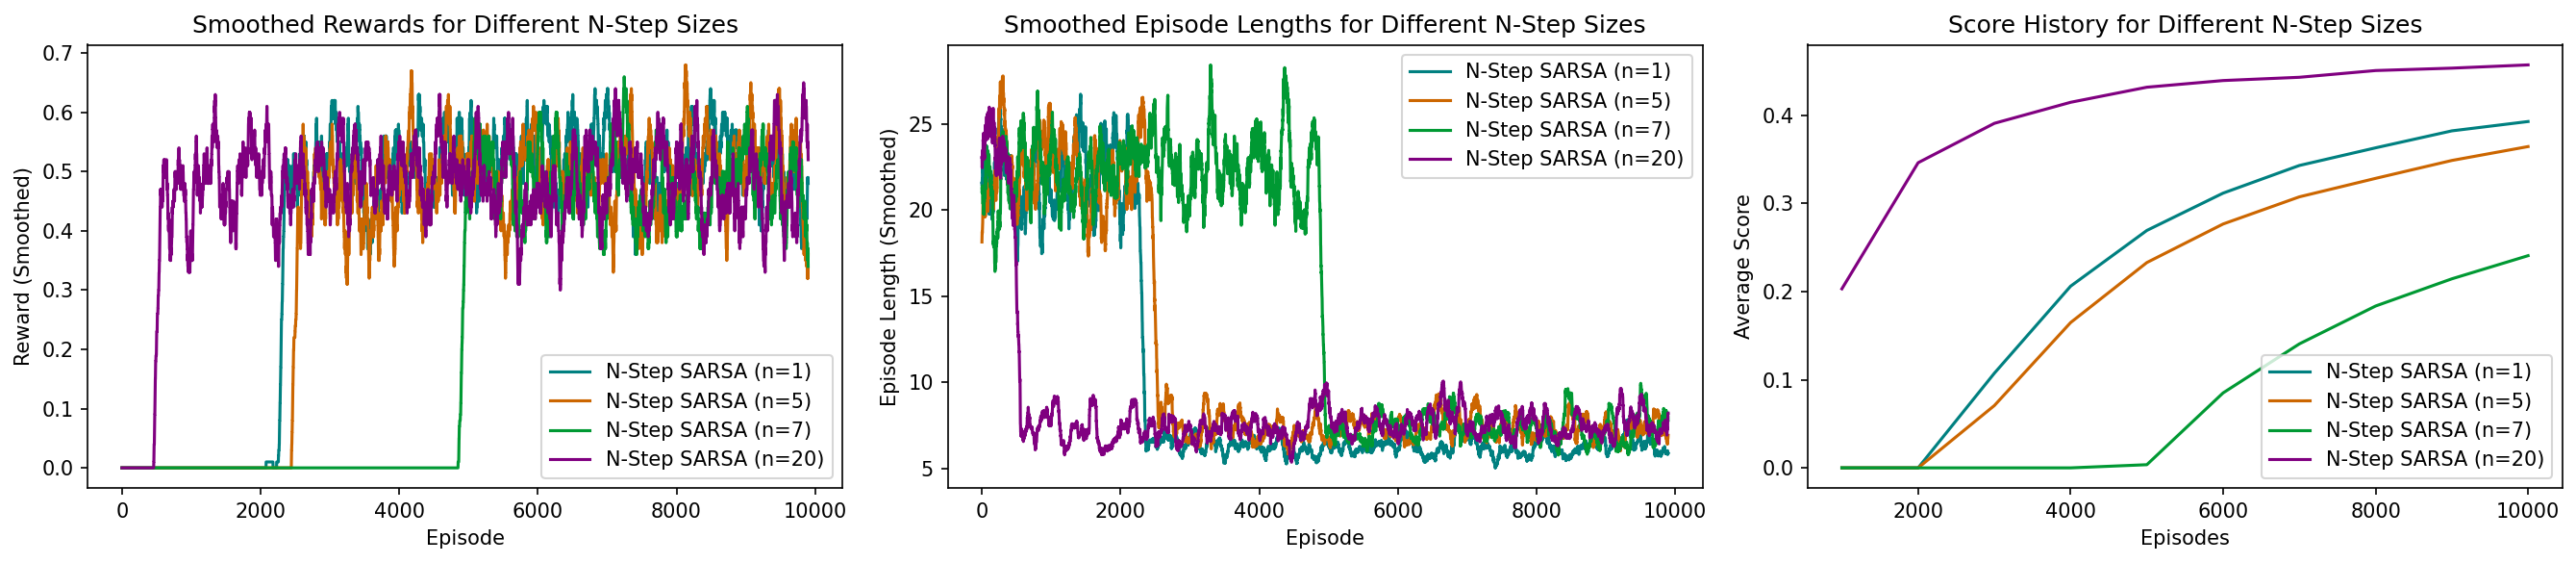

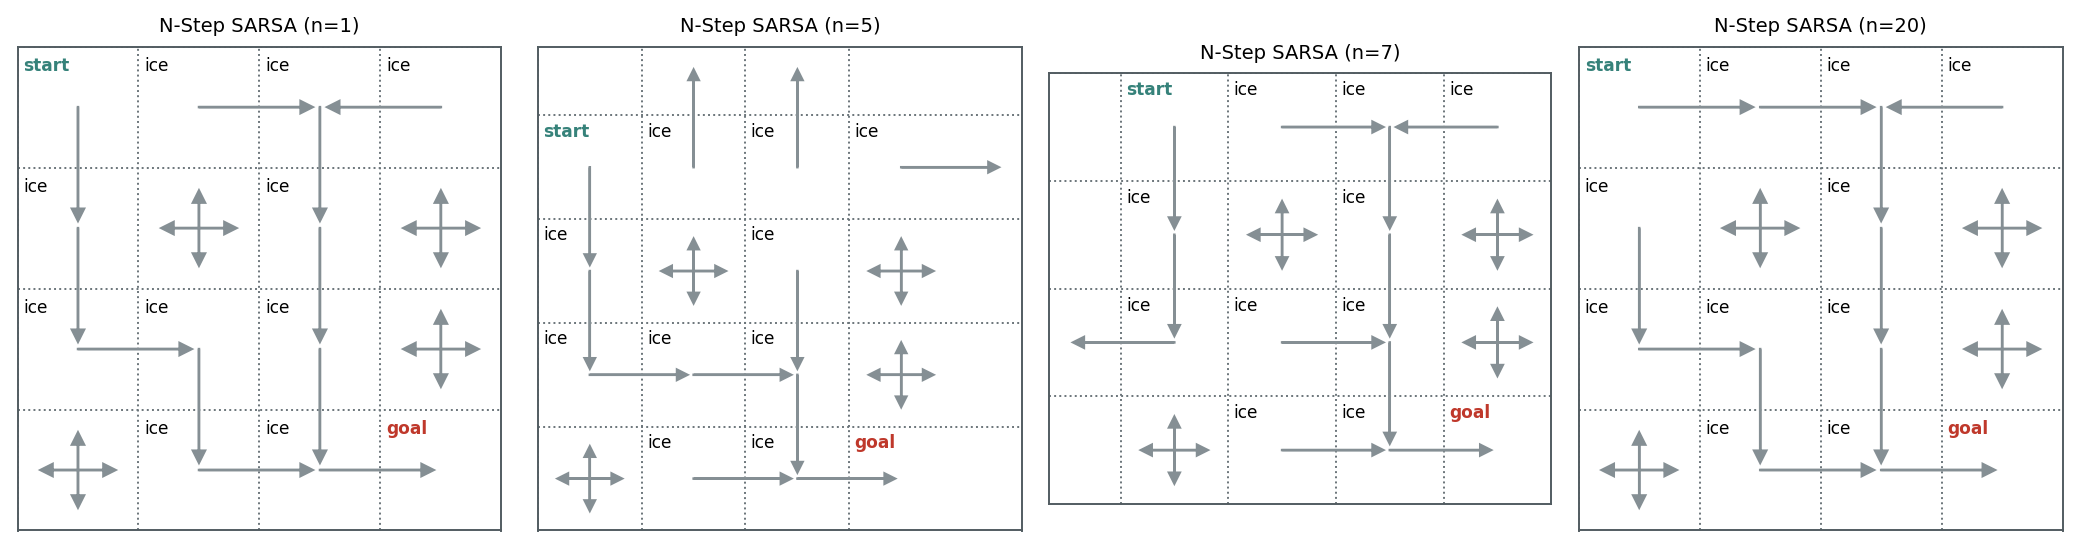

FrozenLake-v1, Slippery=True, γ=0.9, num_episodes=10000, α=0.2:


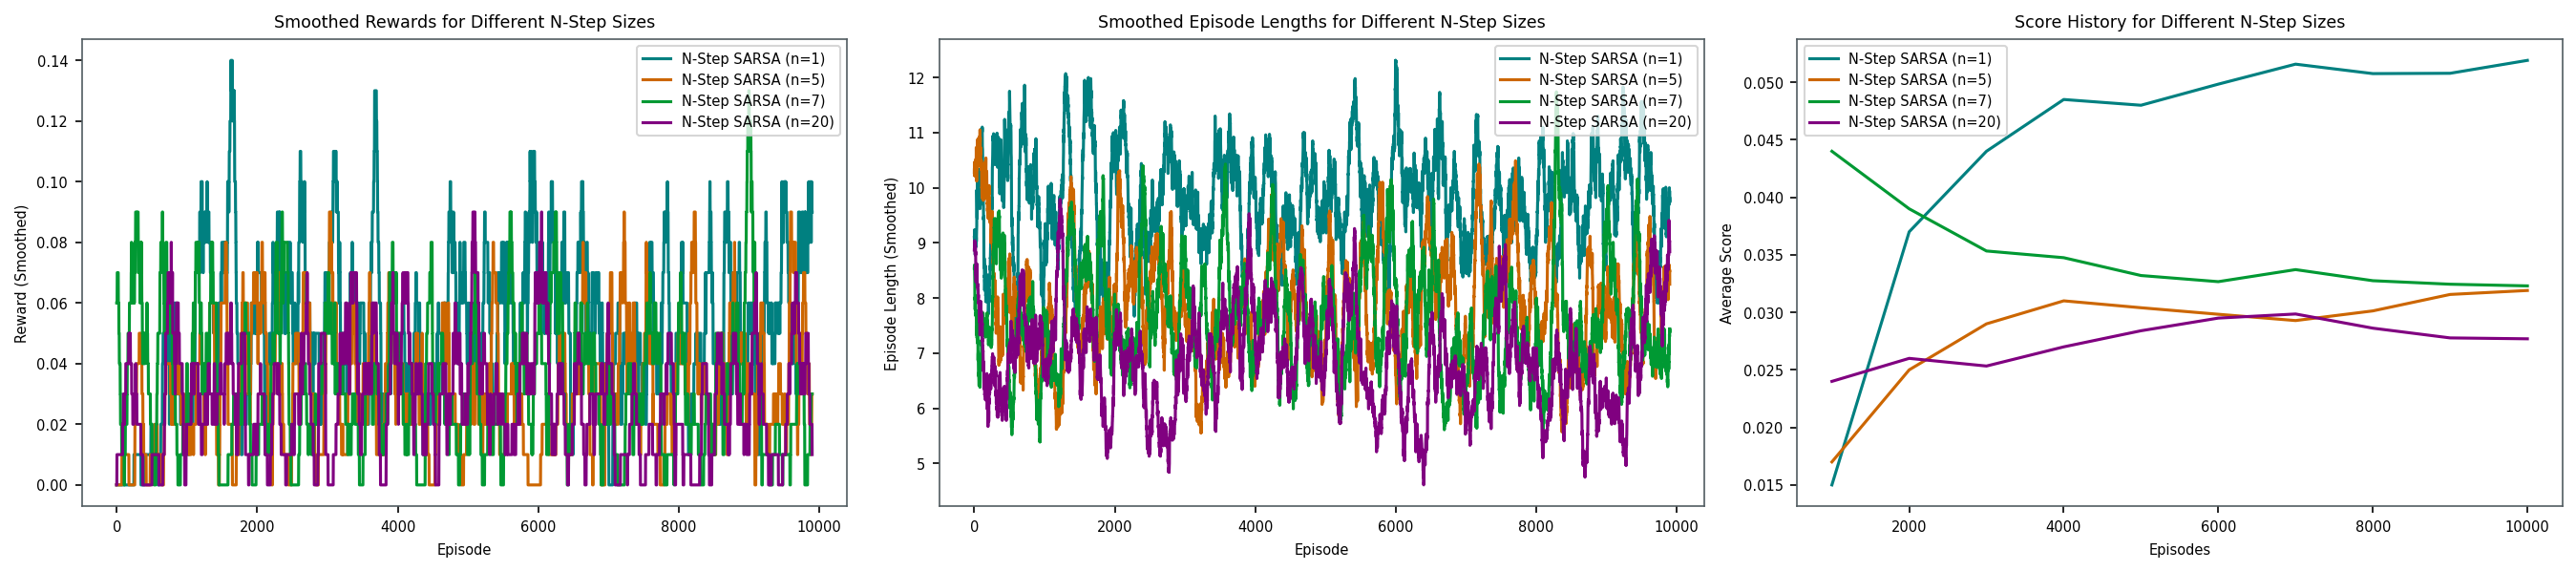

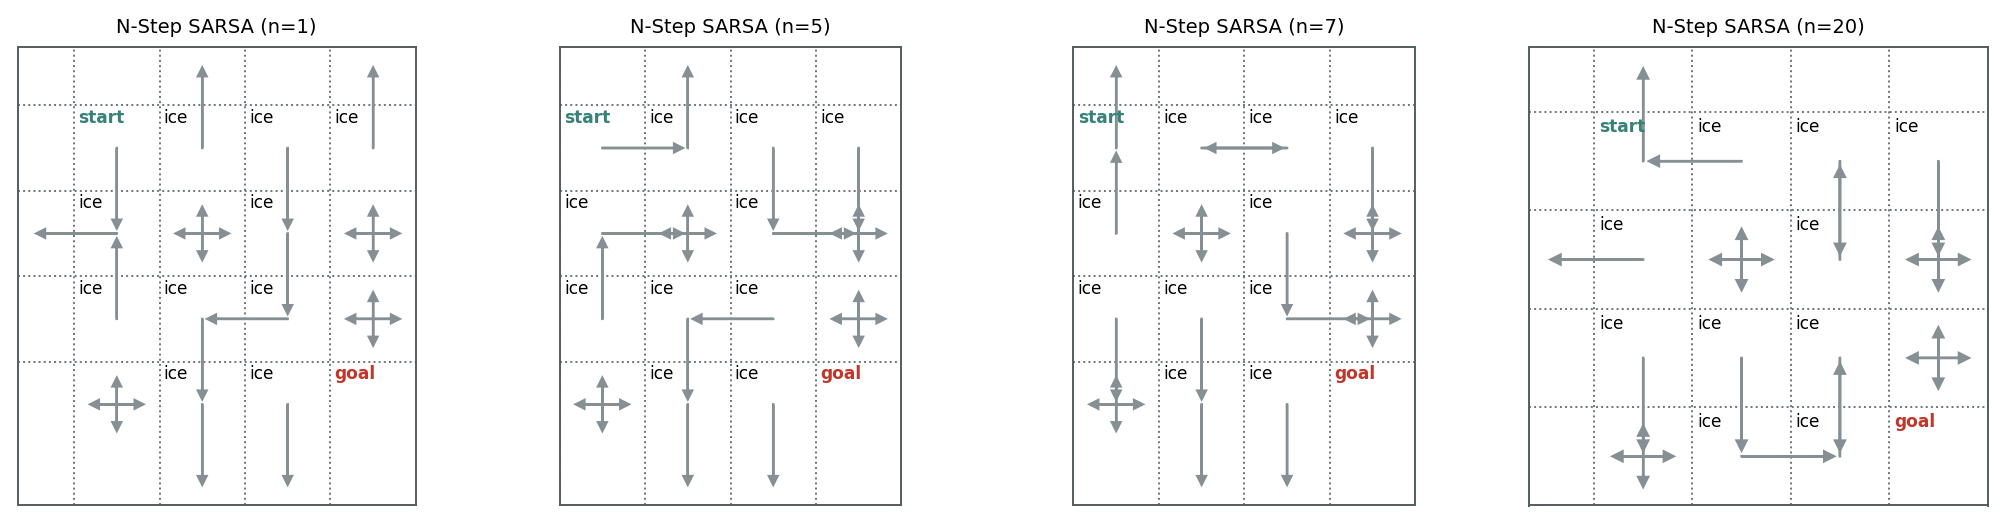

FrozenLake-v1, Slippery=False, γ=1.0, num_episodes=10000, α=0.2:


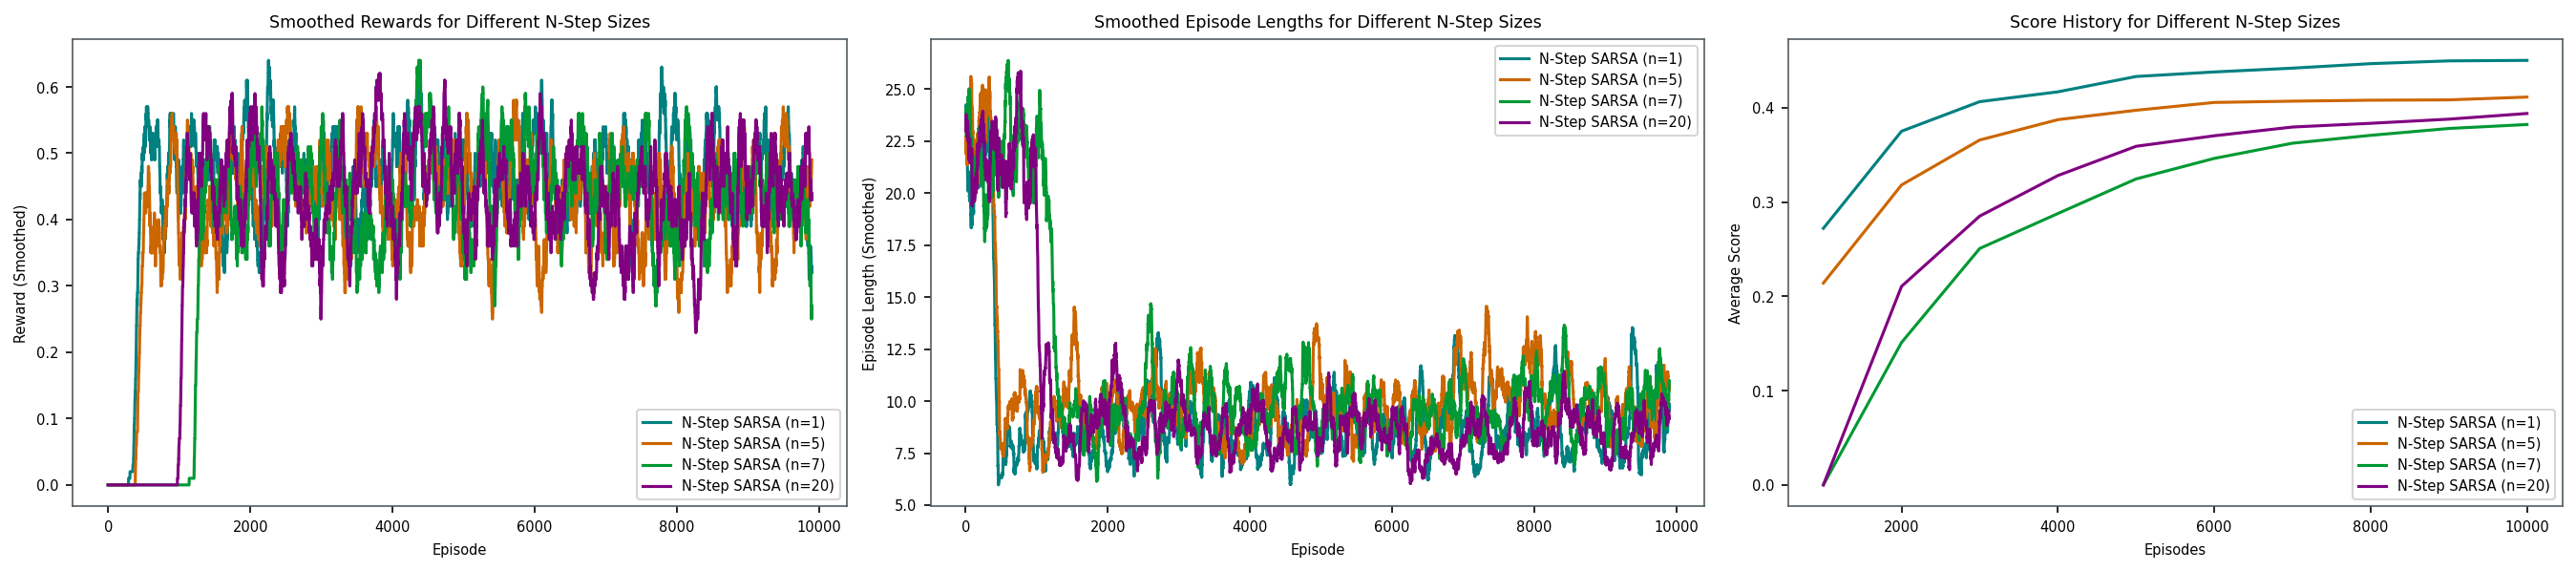

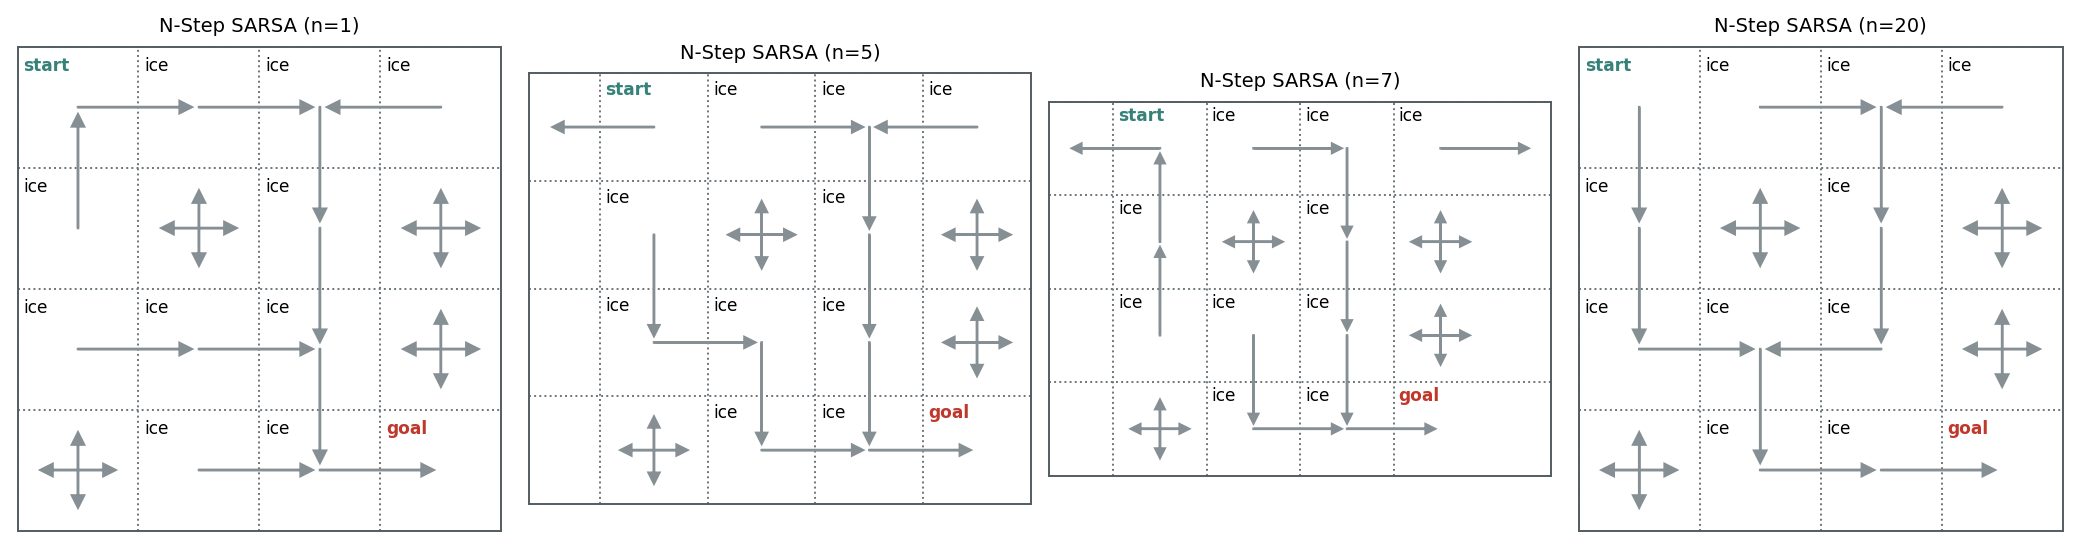

FrozenLake-v1, Slippery=True, γ=1.0, num_episodes=10000, α=0.2:


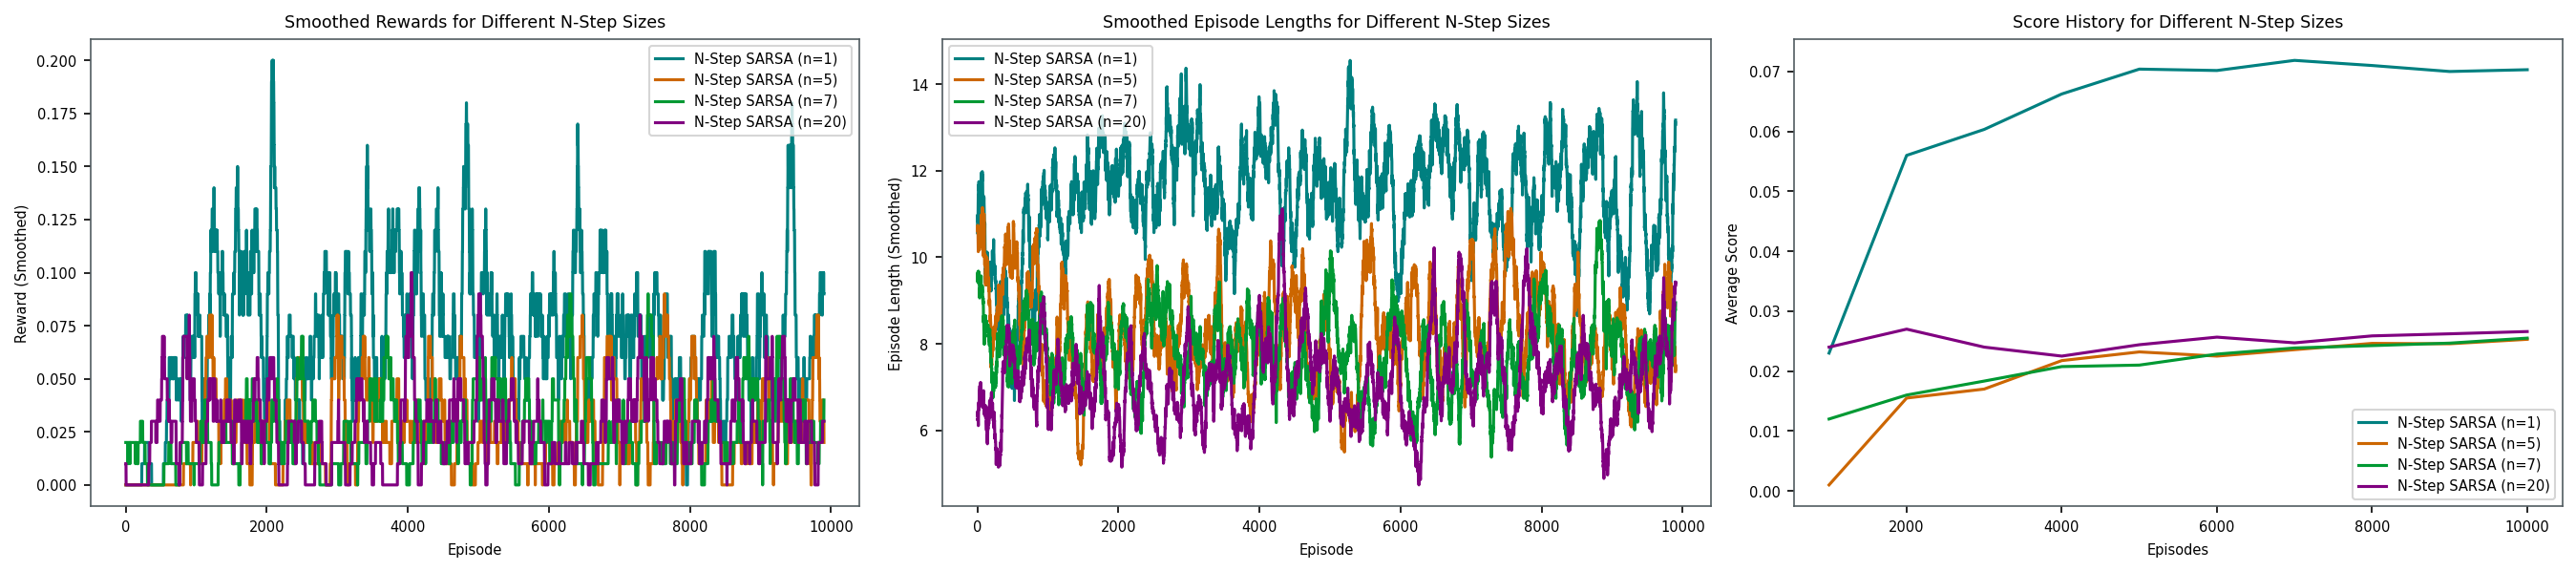

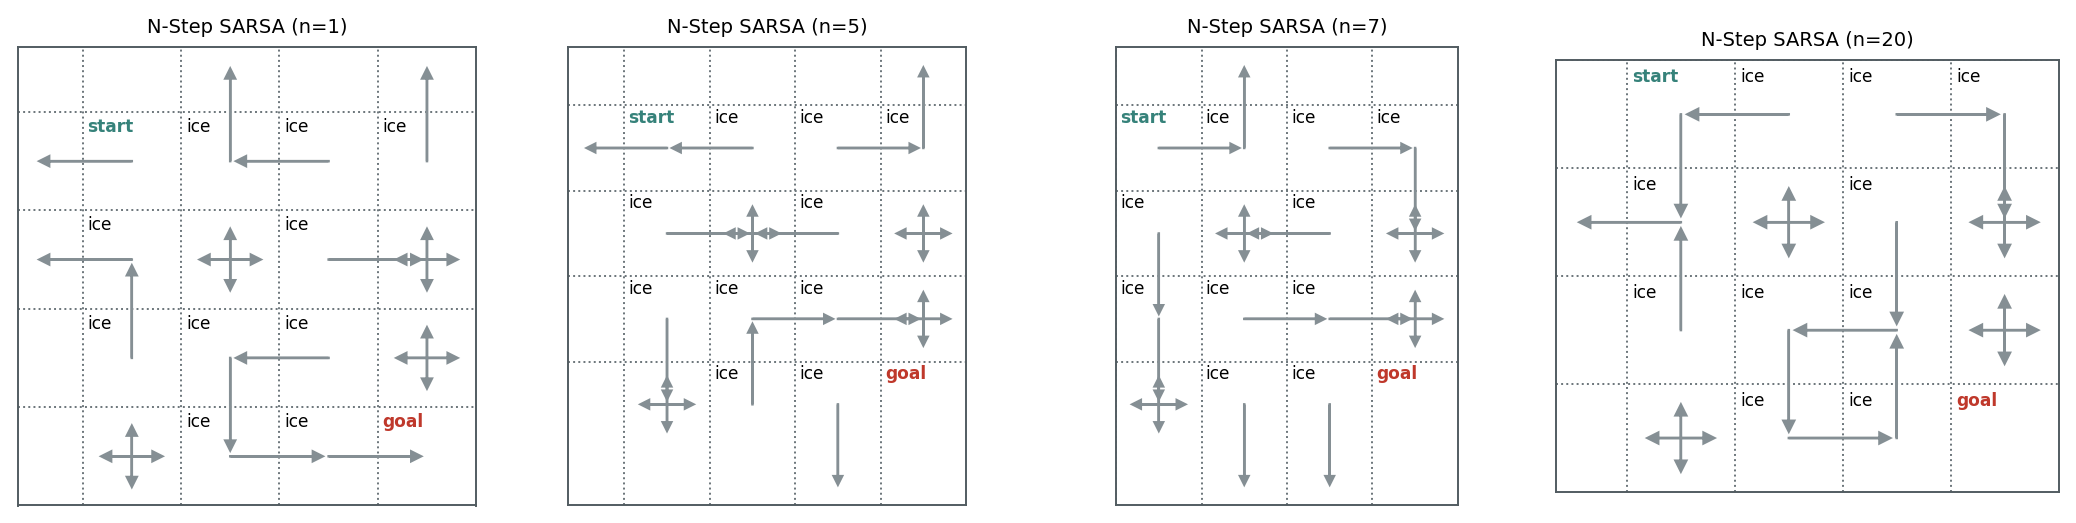

In [ ]:
name = 'FrozenLake-v1'
run_n_step_sarsa_experiment(name=name)

FrozenLake8x8-v1, Slippery=False, γ=0.9, num_episodes=100000, α=0.8:


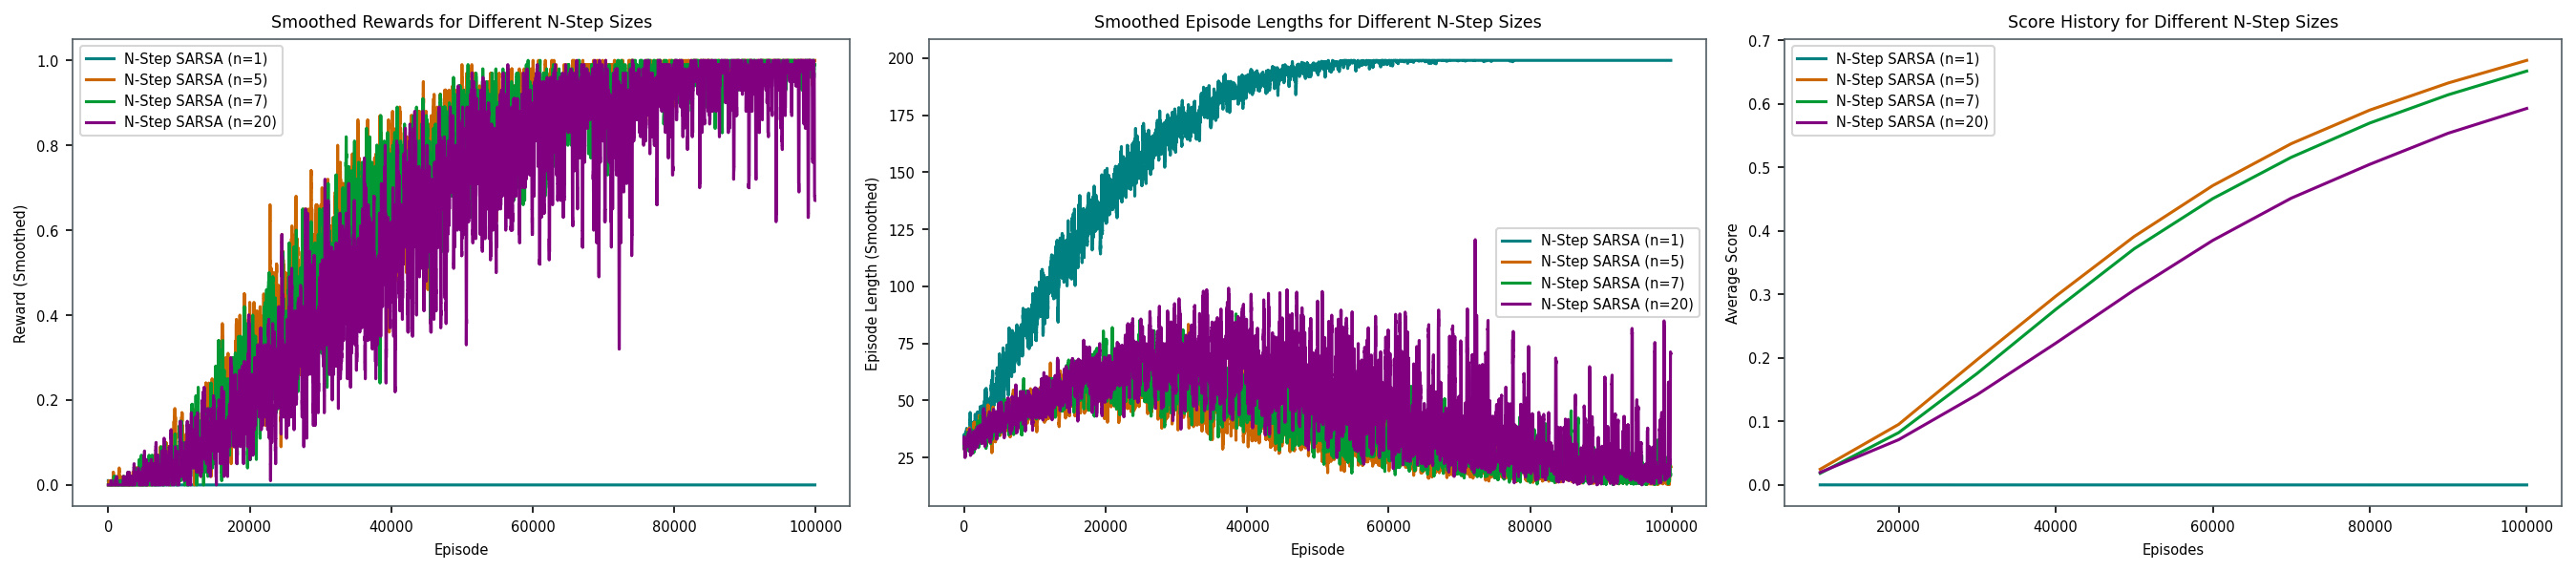

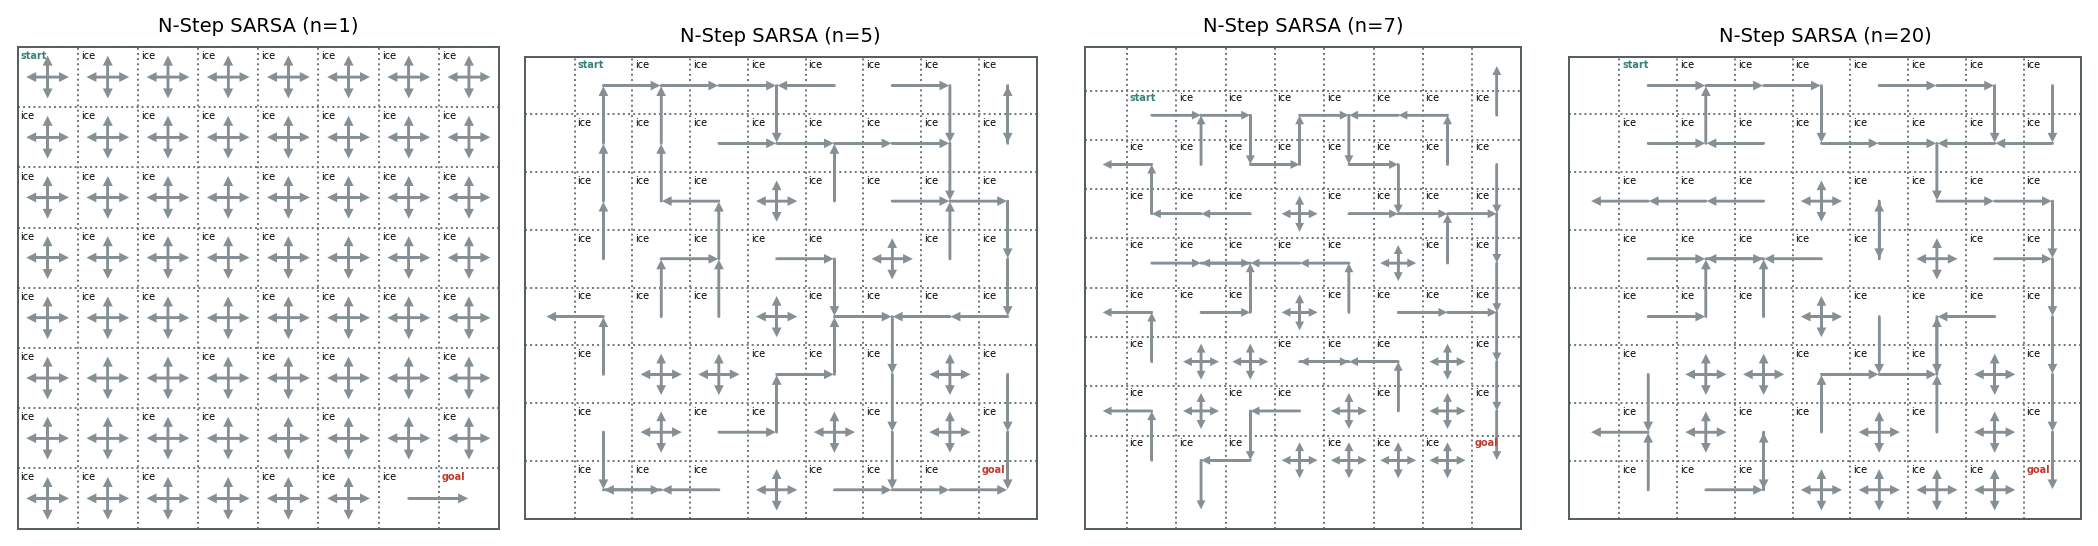

FrozenLake8x8-v1, Slippery=True, γ=0.9, num_episodes=100000, α=0.8:


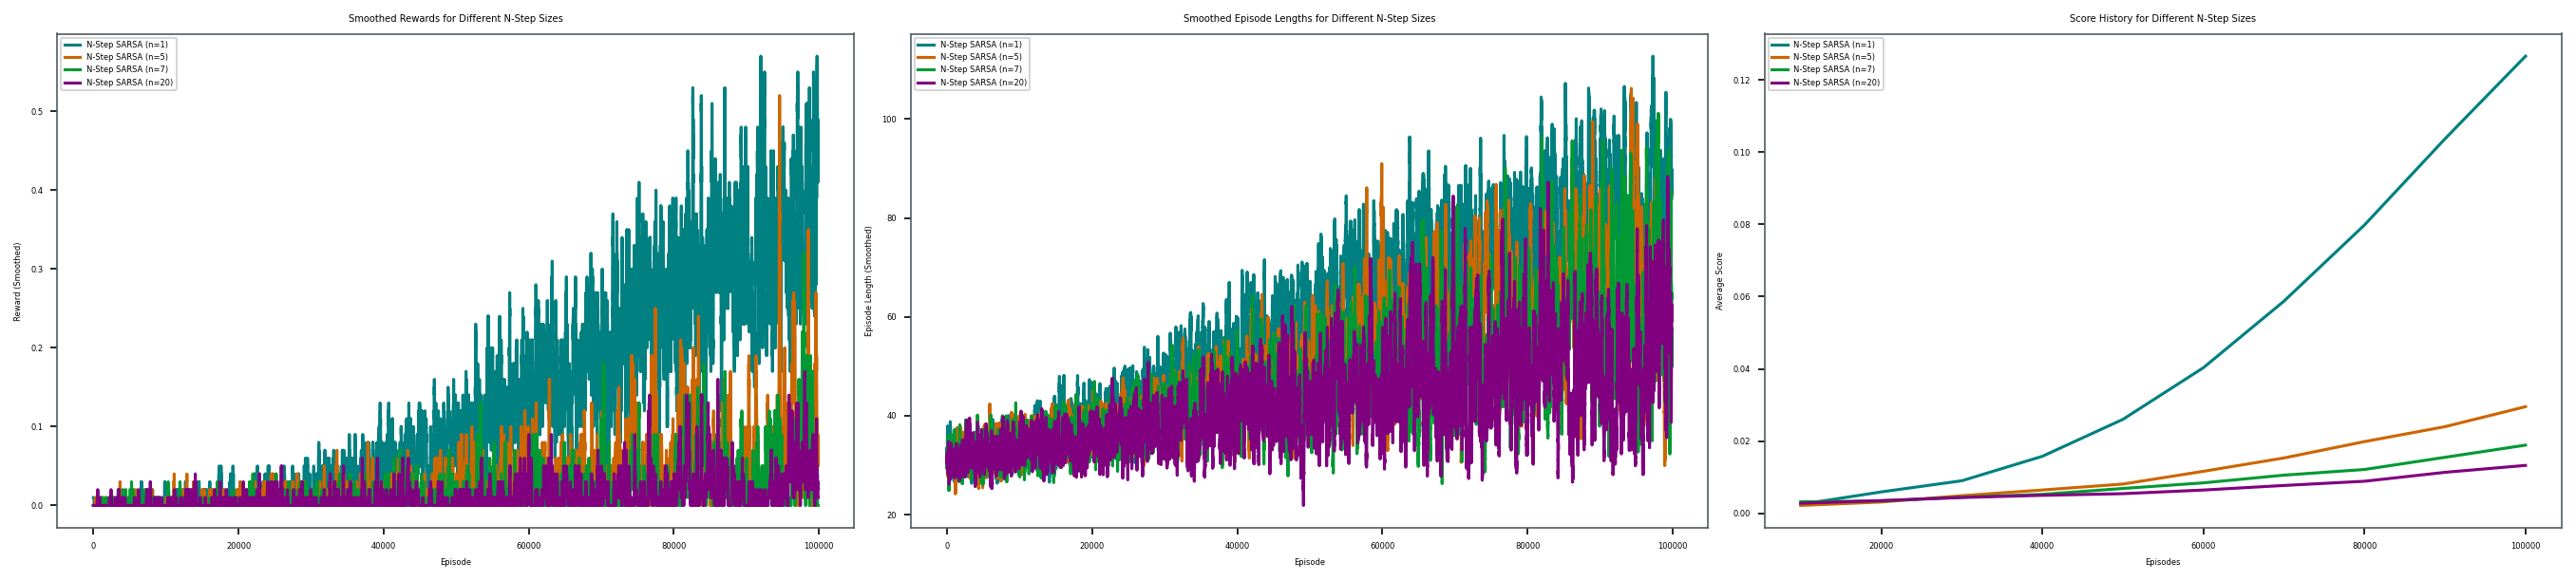

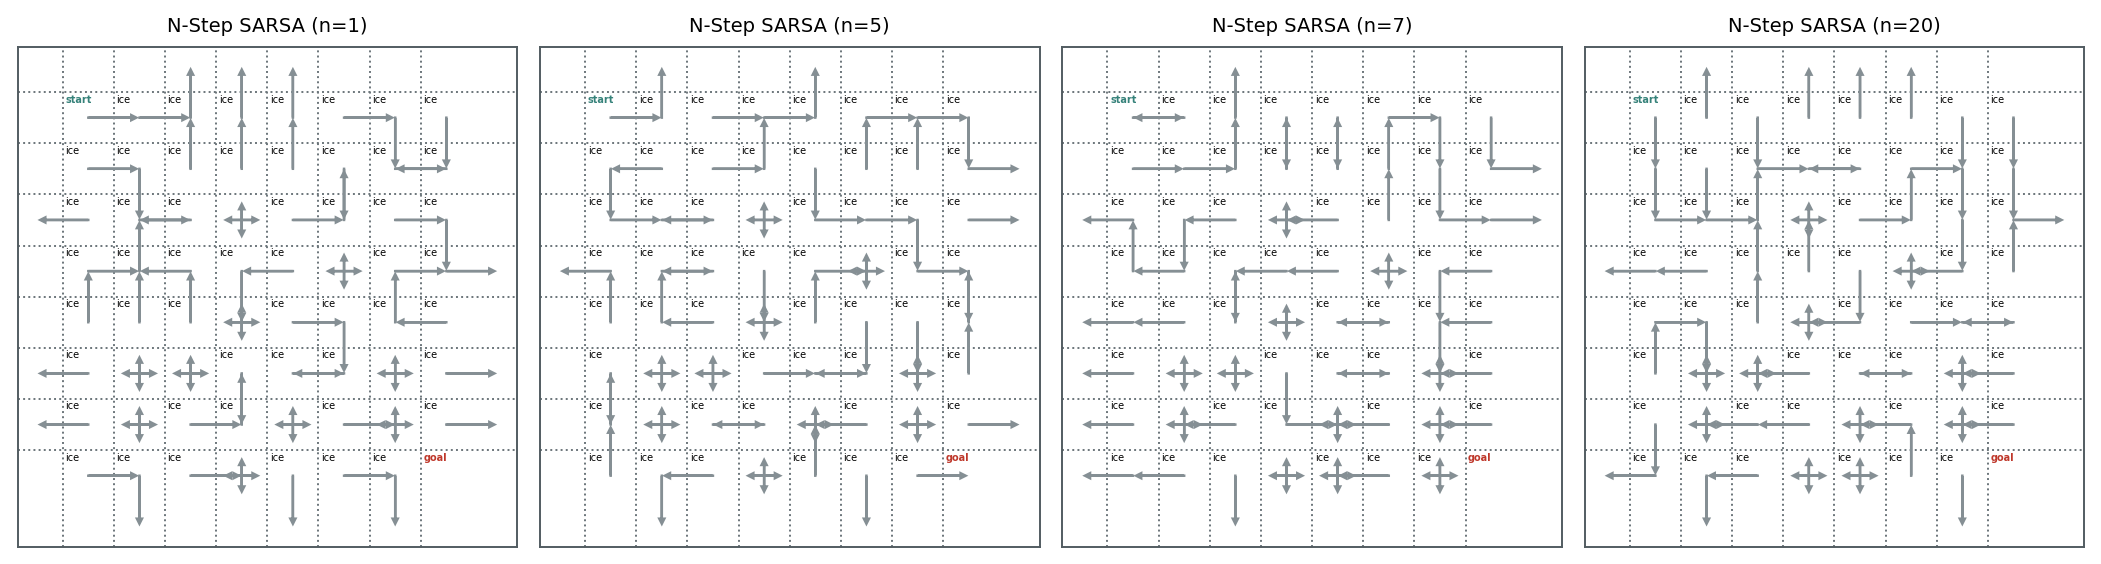

FrozenLake8x8-v1, Slippery=False, γ=1.0, num_episodes=100000, α=0.8:


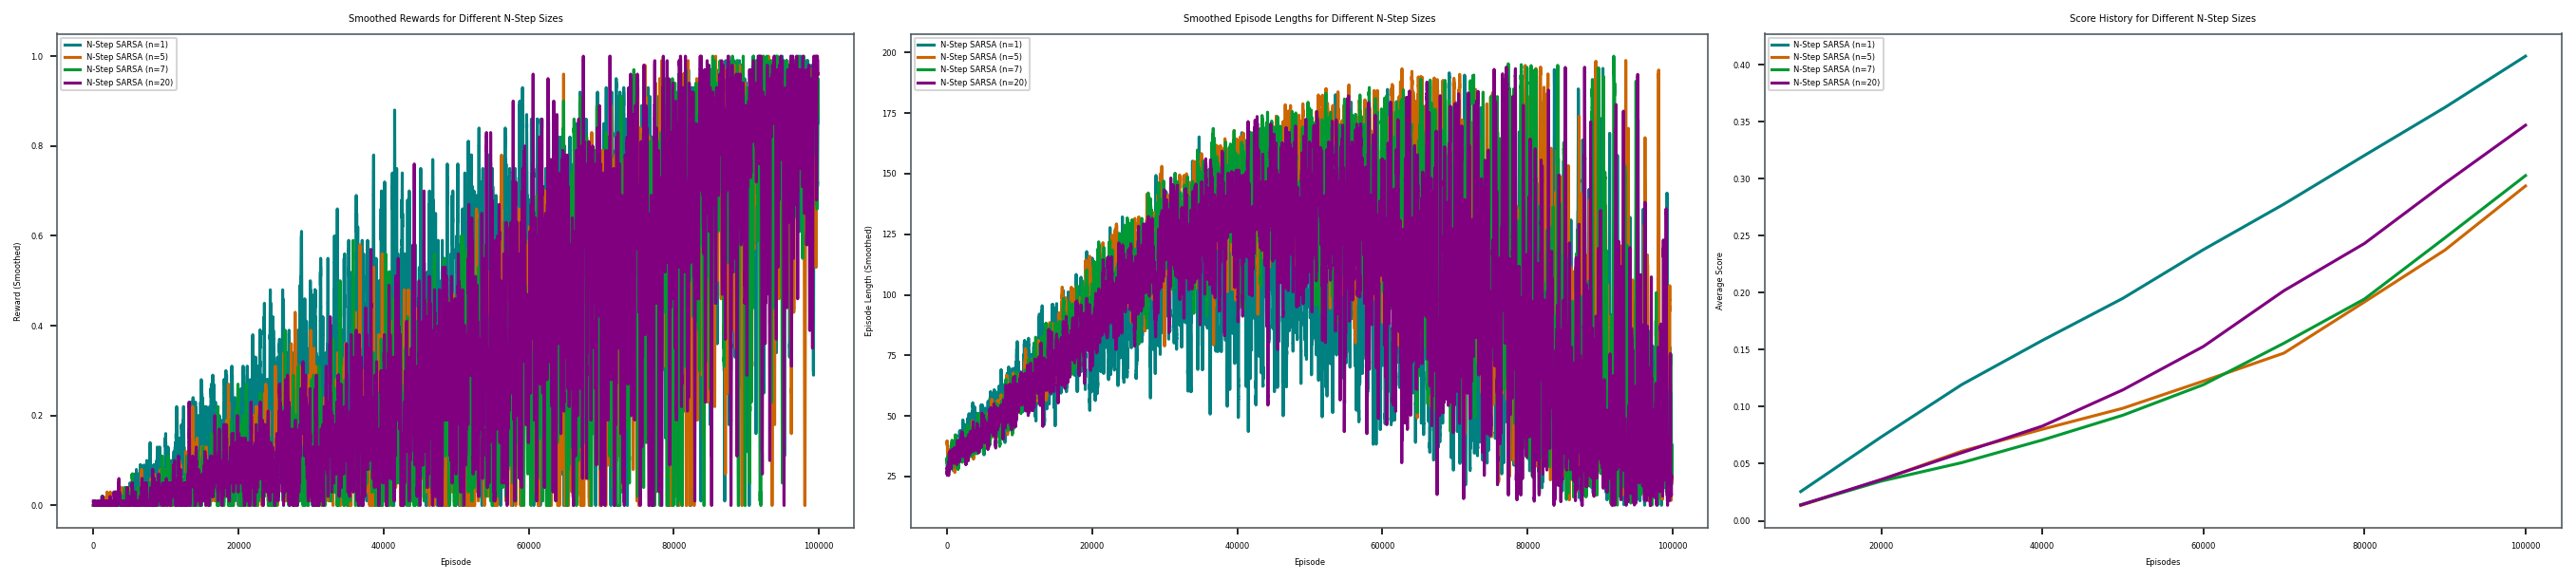

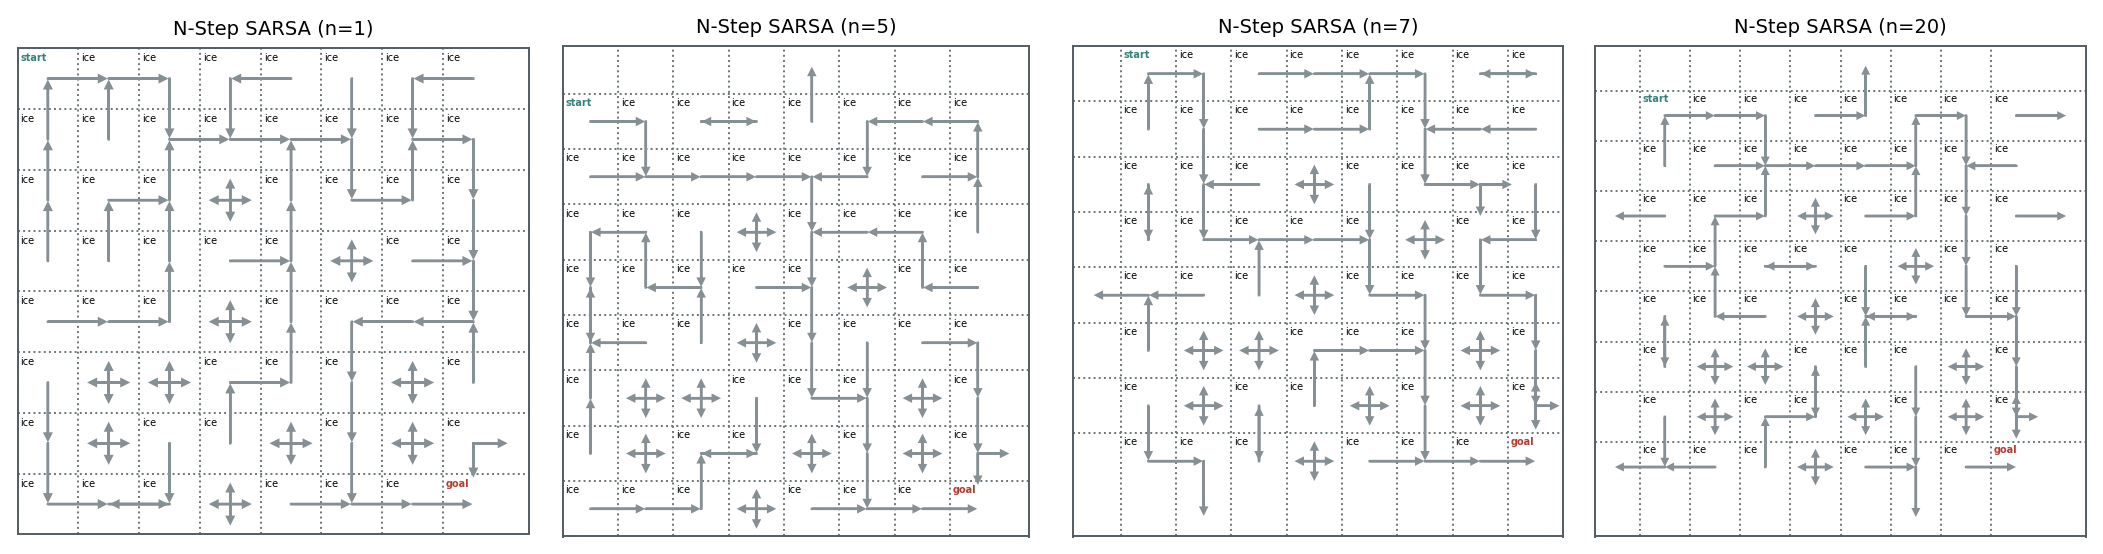

FrozenLake8x8-v1, Slippery=True, γ=1.0, num_episodes=100000, α=0.8:


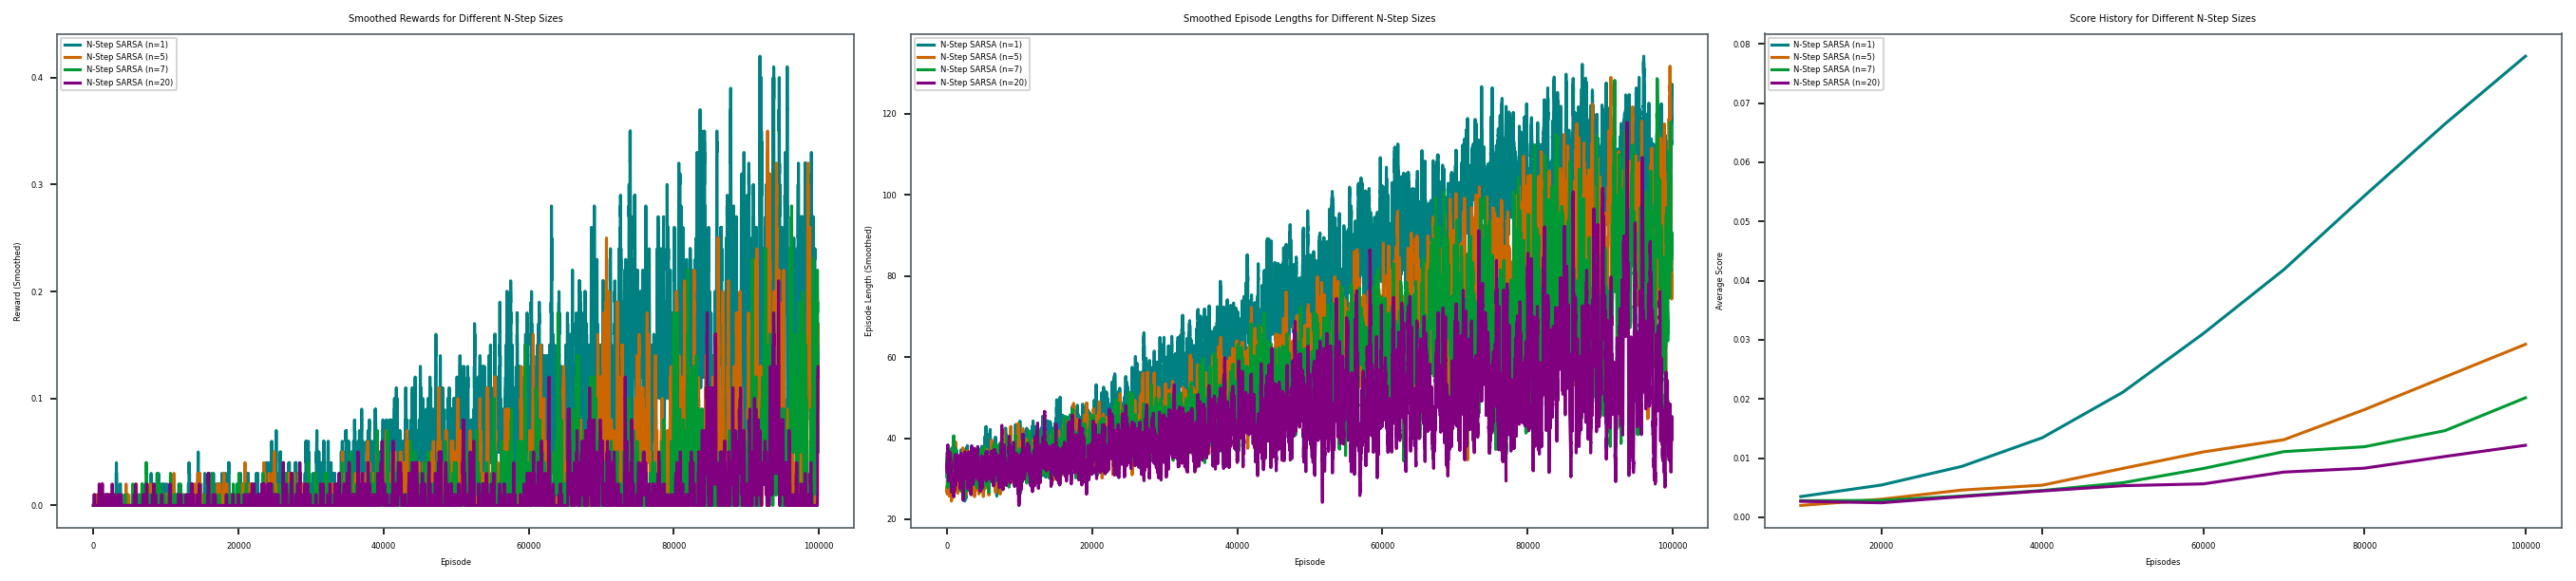

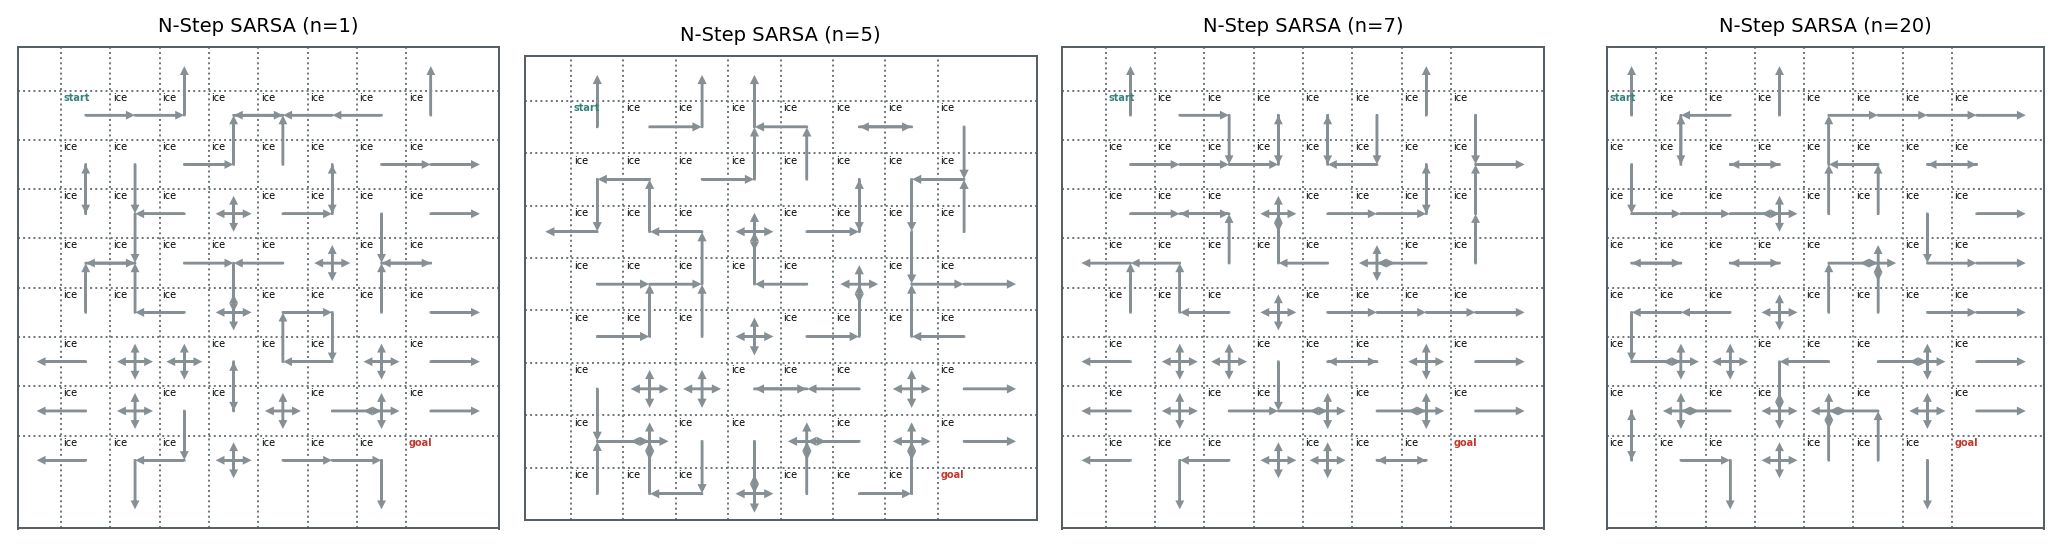

In [17]:
name = 'FrozenLake8x8-v1'
run_n_step_sarsa_experiment(name=name)

### Q-Learning

In [18]:
def q_learning(env, num_episodes=10000, gamma=0.9, 
               max_epsilon=1.0, min_epsilon=0.001, decay_rate=0.00005, 
               alpha=0.2):
    Q = np.zeros([env.observation_space.n, env.action_space.n])
    
    stats_rewards = defaultdict(float)
    stats_lengths = defaultdict(float)

    qtable_history = []
    score_history = []
    rewards = []
    
    for episode in range(1, num_episodes + 1):
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
        
        s = env.reset()
        
        for t in itertools.count():
            p_a = random_epsilon_greedy_policy(Q, epsilon, s, env.action_space.n)
            a = np.random.choice(np.arange(len(p_a)), p=p_a)
            
            next_s, reward, done, _ = env.step(a)
            
            Q[s][a] += alpha * (reward + gamma * np.max(Q[next_s]) - Q[s][a])
            
            stats_rewards[episode] += reward
            stats_lengths[episode] = t
            
            if done:
                break
            
            s = next_s
        
        rewards.append(stats_rewards[episode])

        if episode % (num_episodes / 10) == 0:
            # print("Episode count: " + str(episode) + ", epsilon = " + str(epsilon))
            qtable_history.append(Q.copy())
            score_history.append(sum(rewards)/episode)

    # print("Score over time: " + str(sum(rewards)/num_episodes))

    env.close()
    
    return Q, stats_rewards, stats_lengths, qtable_history, score_history

### Experiment

### FrozenLake-v1

In [19]:
name = 'FrozenLake-v1'

FrozenLake-v1, Slippery=False, γ=0.9, num_episodes=10000, α=0.2, use_epsilon_decay=False :


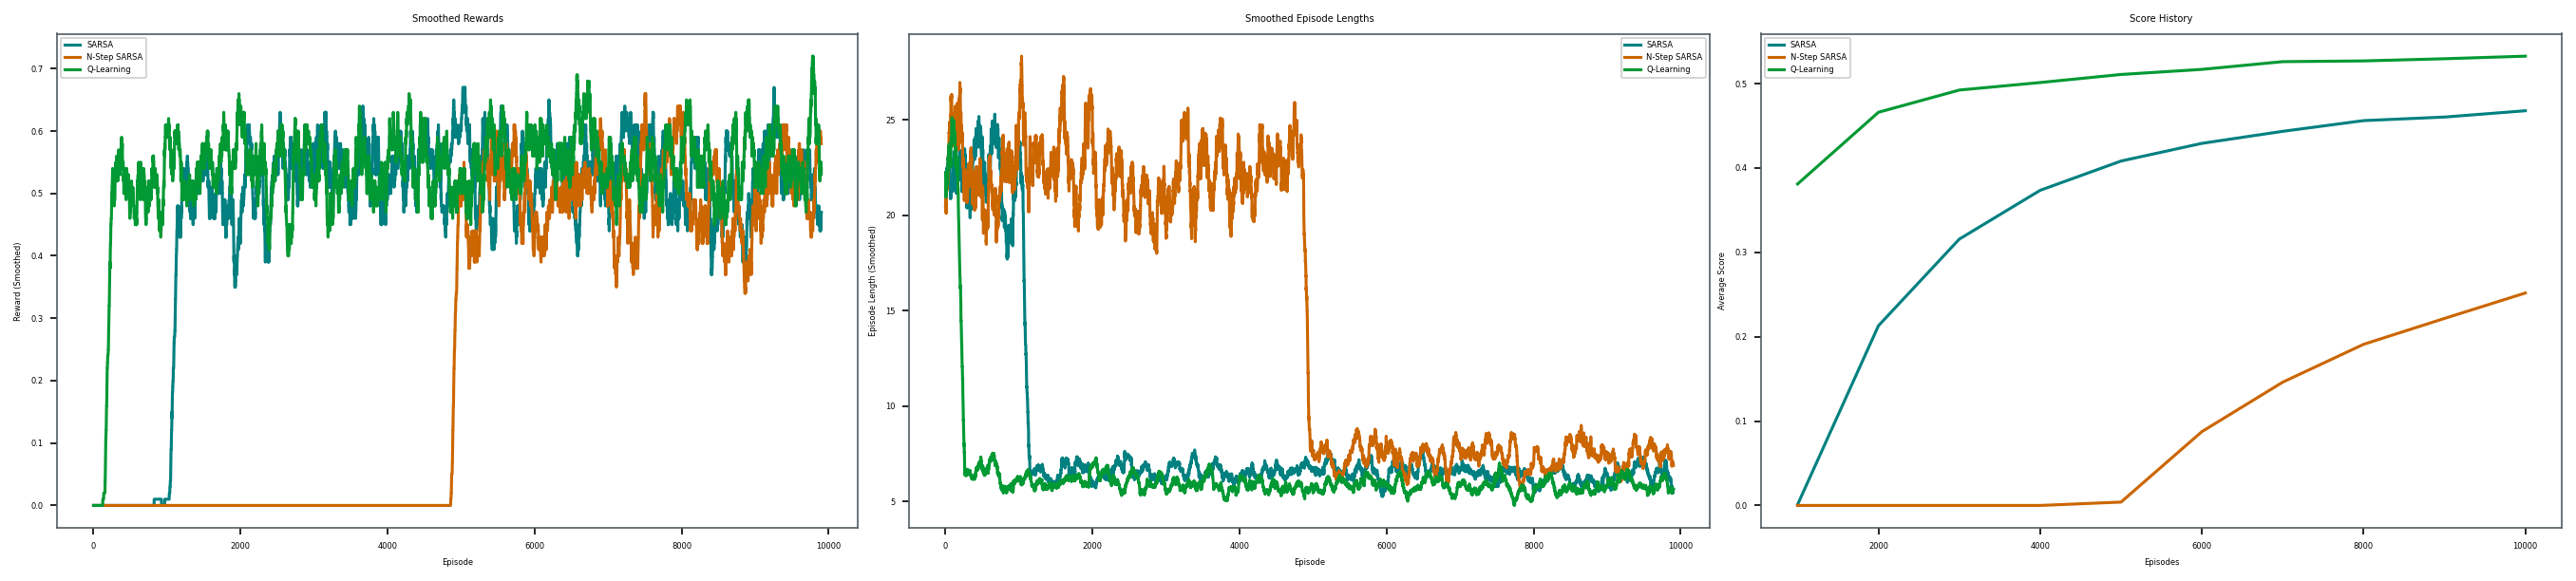

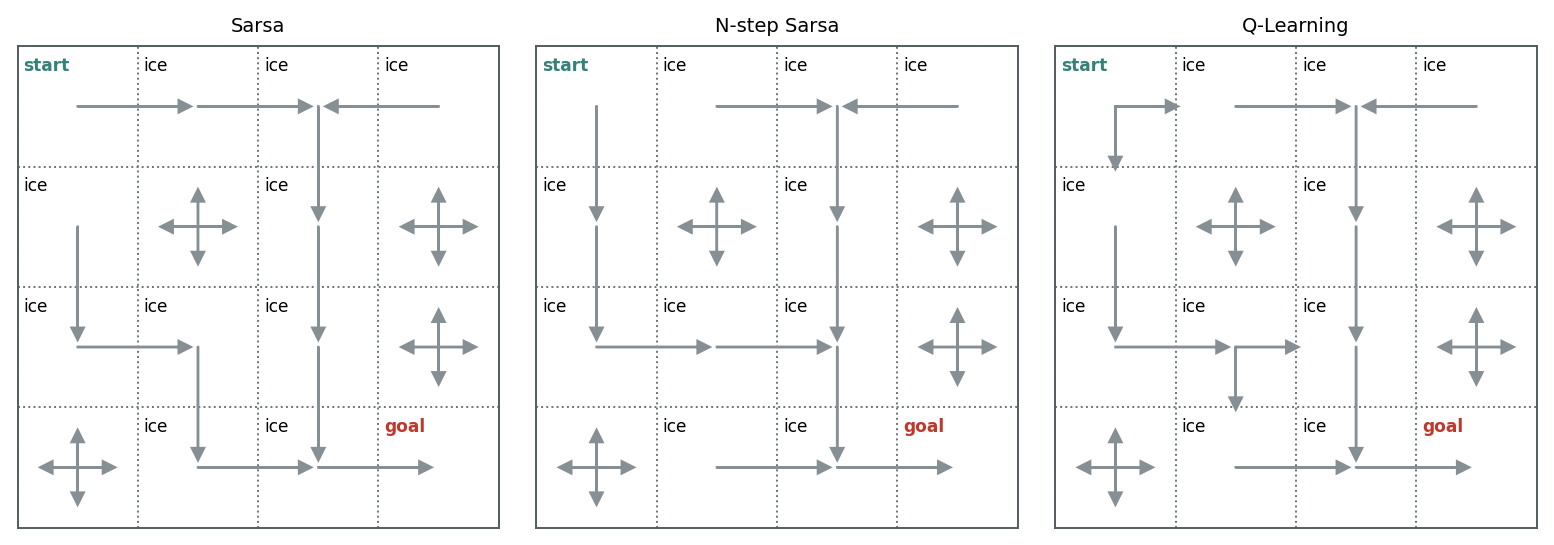

+--------------+----------------+--------------+
| SARSA        | N-Step SARSA   | Q-Learning   |
+==============+================+==============+
| [0, 0, 1, 0] | [0, 1, 0, 0]   | [0, 1, 0, 0] |
| [0, 0, 1, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 1, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 1, 0, 0]   | [0, 1, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 1, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 1, 0]   | [0, 0, 1, 0] |
| [0, 0, 0, 0] | [0, 0, 1, 0]   | [0, 1, 0, 0] |
| [0, 1, 0, 0] | [0, 1, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 1, 0] |
| [0, 0, 1, 0] | [0, 0, 1, 0]   | [0, 0, 1, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
+--------------+----------------+--------------+
FrozenLake-v1, Slipp

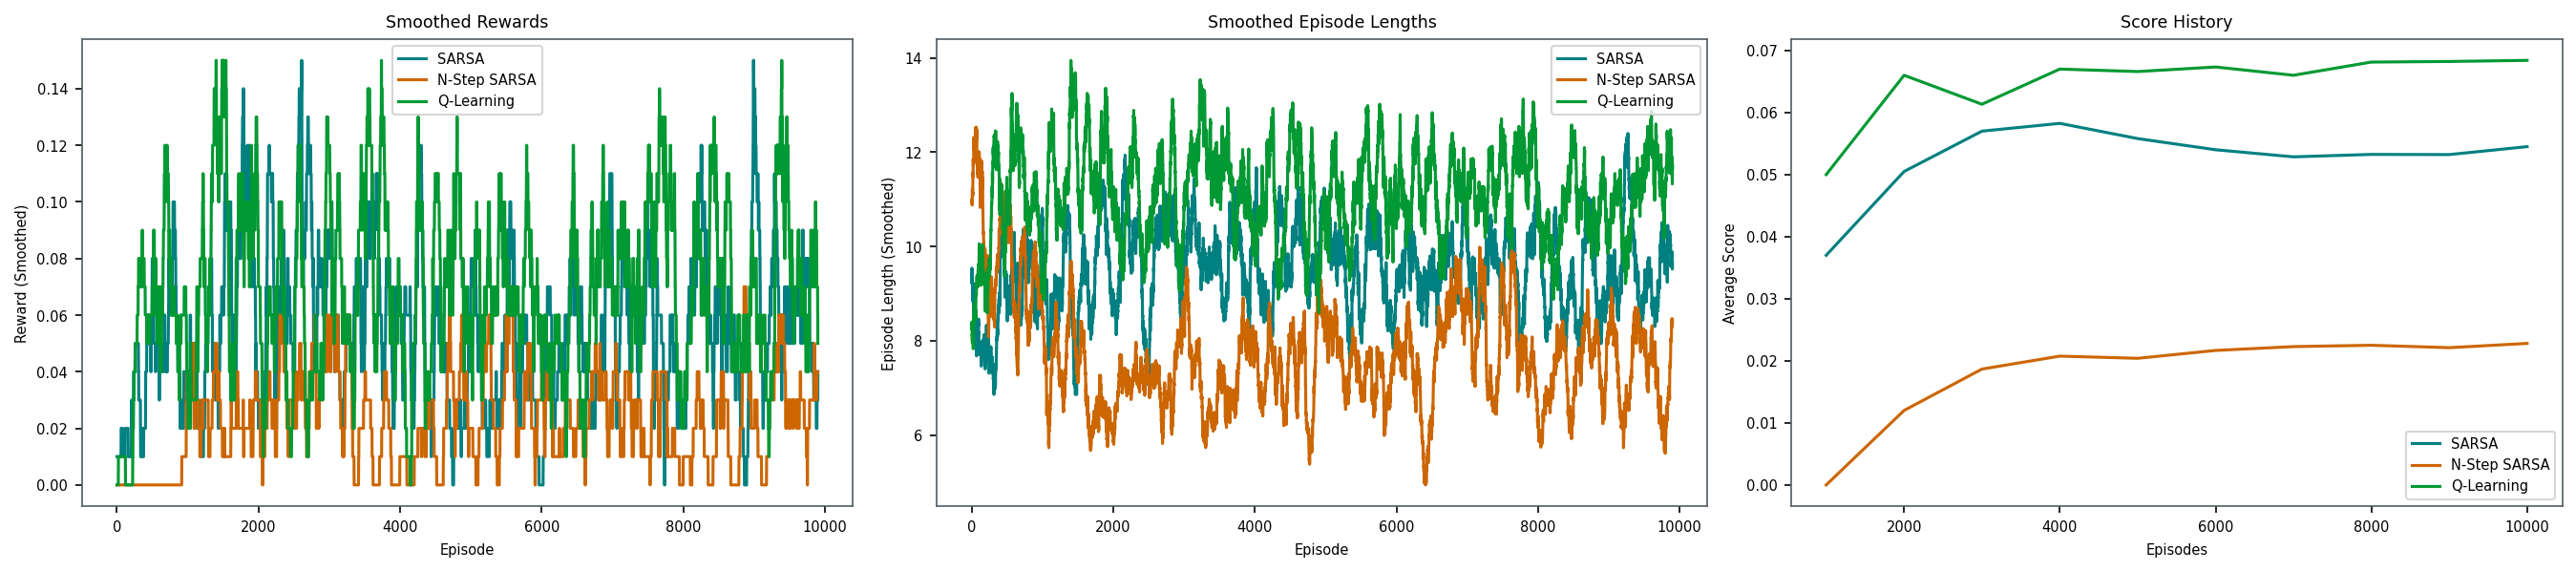

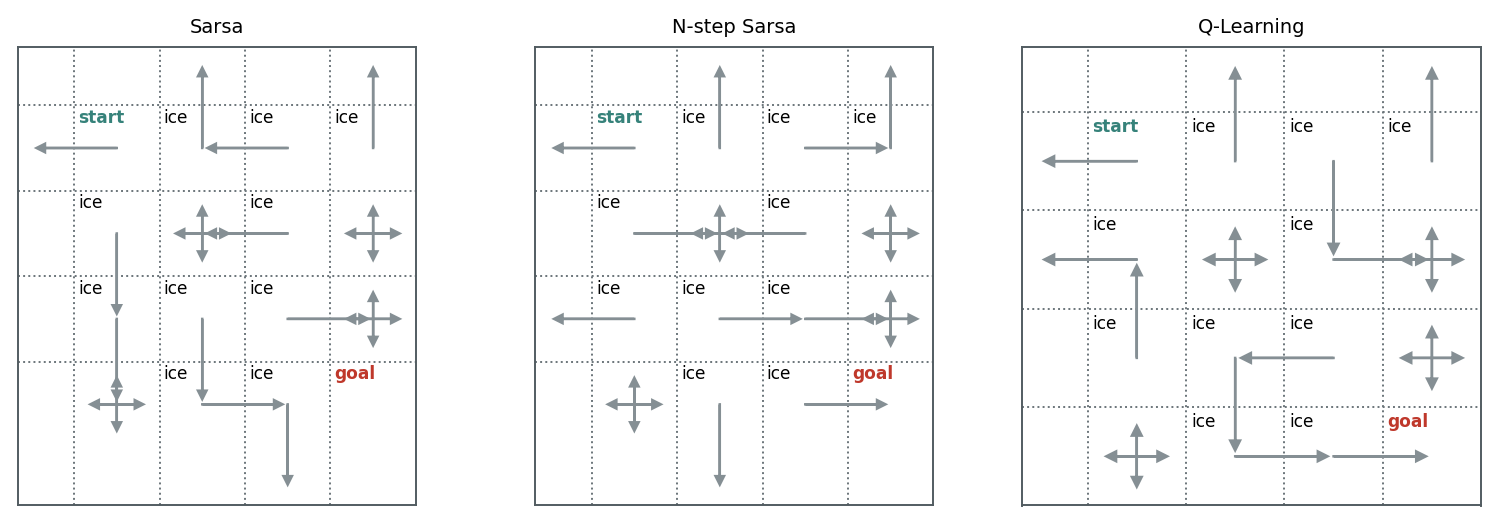

+--------------+----------------+--------------+
| SARSA        | N-Step SARSA   | Q-Learning   |
+==============+================+==============+
| [1, 0, 0, 0] | [1, 0, 0, 0]   | [1, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 1, 0, 0] | [0, 0, 1, 0]   | [1, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 1, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 1] |
| [0, 1, 0, 0] | [0, 0, 0, 0]   | [0, 1, 0, 0] |
| [0, 0, 1, 0] | [0, 0, 0, 0]   | [1, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 1, 0] | [0, 0, 0, 0]   | [0, 0, 1, 0] |
| [0, 1, 0, 0] | [0, 0, 0, 0]   | [0, 0, 1, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
+--------------+----------------+--------------+
FrozenLake-v1, Slipp

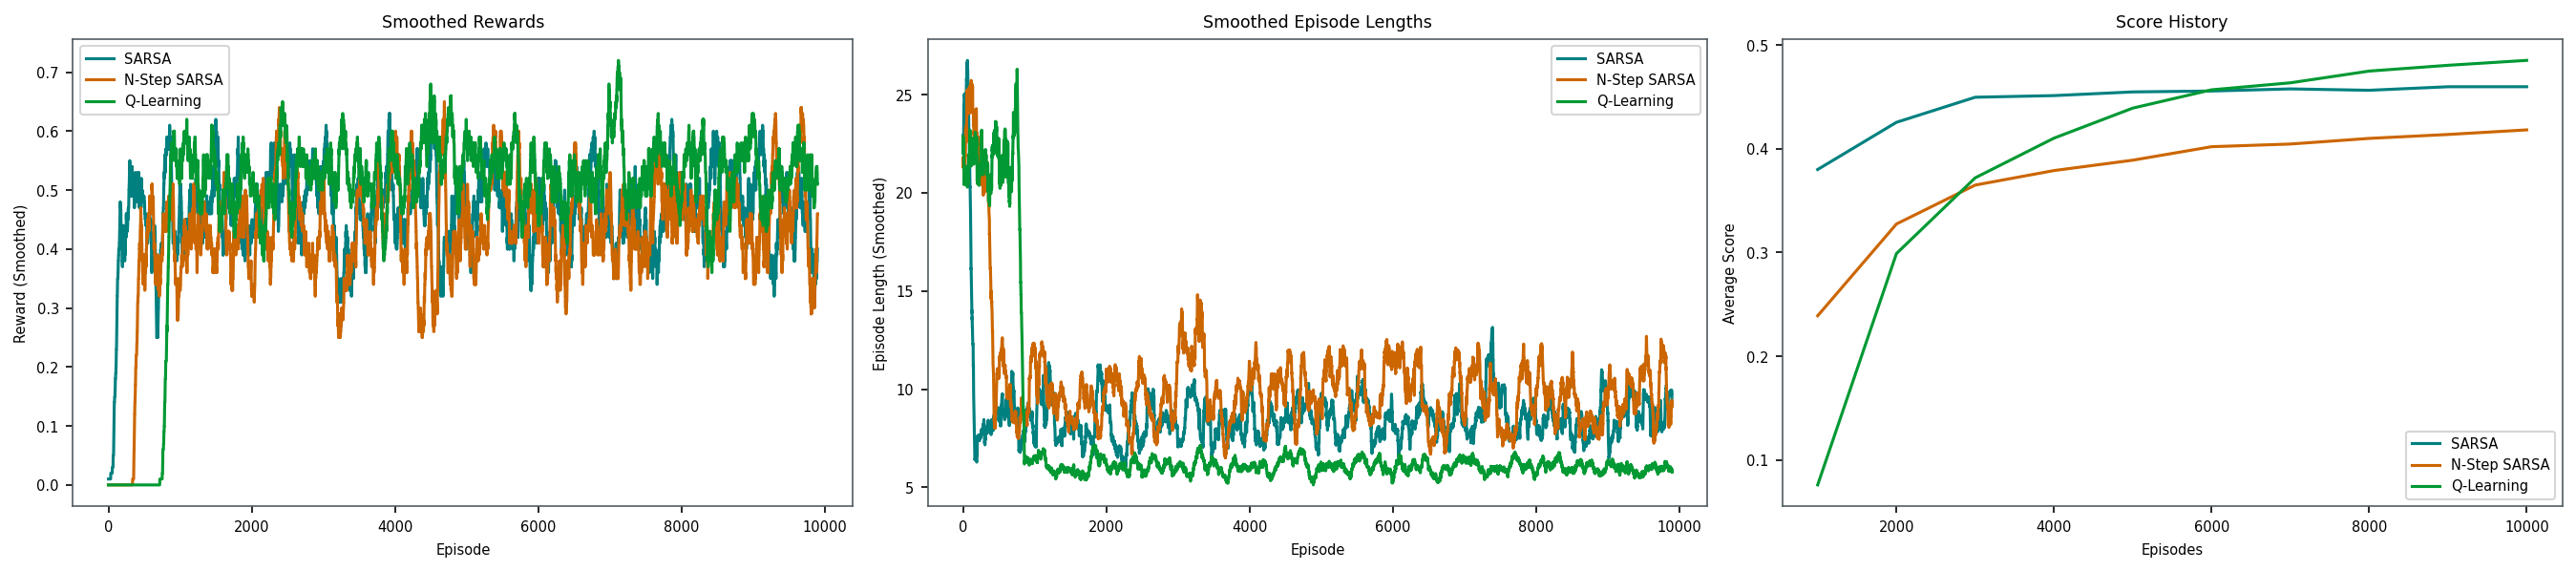

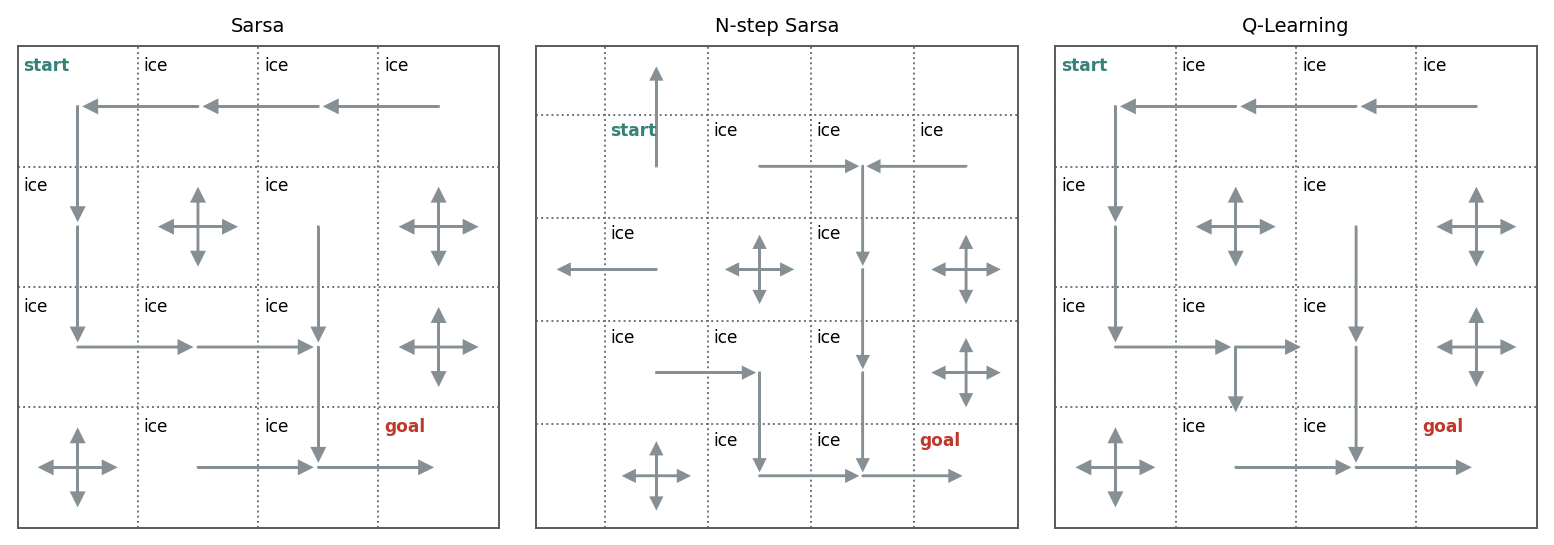

+--------------+----------------+--------------+
| SARSA        | N-Step SARSA   | Q-Learning   |
+==============+================+==============+
| [0, 1, 0, 0] | [0, 0, 0, 1]   | [0, 1, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 1, 0, 0] | [0, 0, 0, 0]   | [0, 1, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 1, 0] | [0, 0, 0, 0]   | [0, 0, 1, 0] |
| [0, 0, 1, 0] | [0, 0, 0, 0]   | [0, 1, 0, 0] |
| [0, 1, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 1, 0] |
| [0, 0, 1, 0] | [0, 0, 0, 0]   | [0, 0, 1, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
+--------------+----------------+--------------+
FrozenLake-v1, Slipp

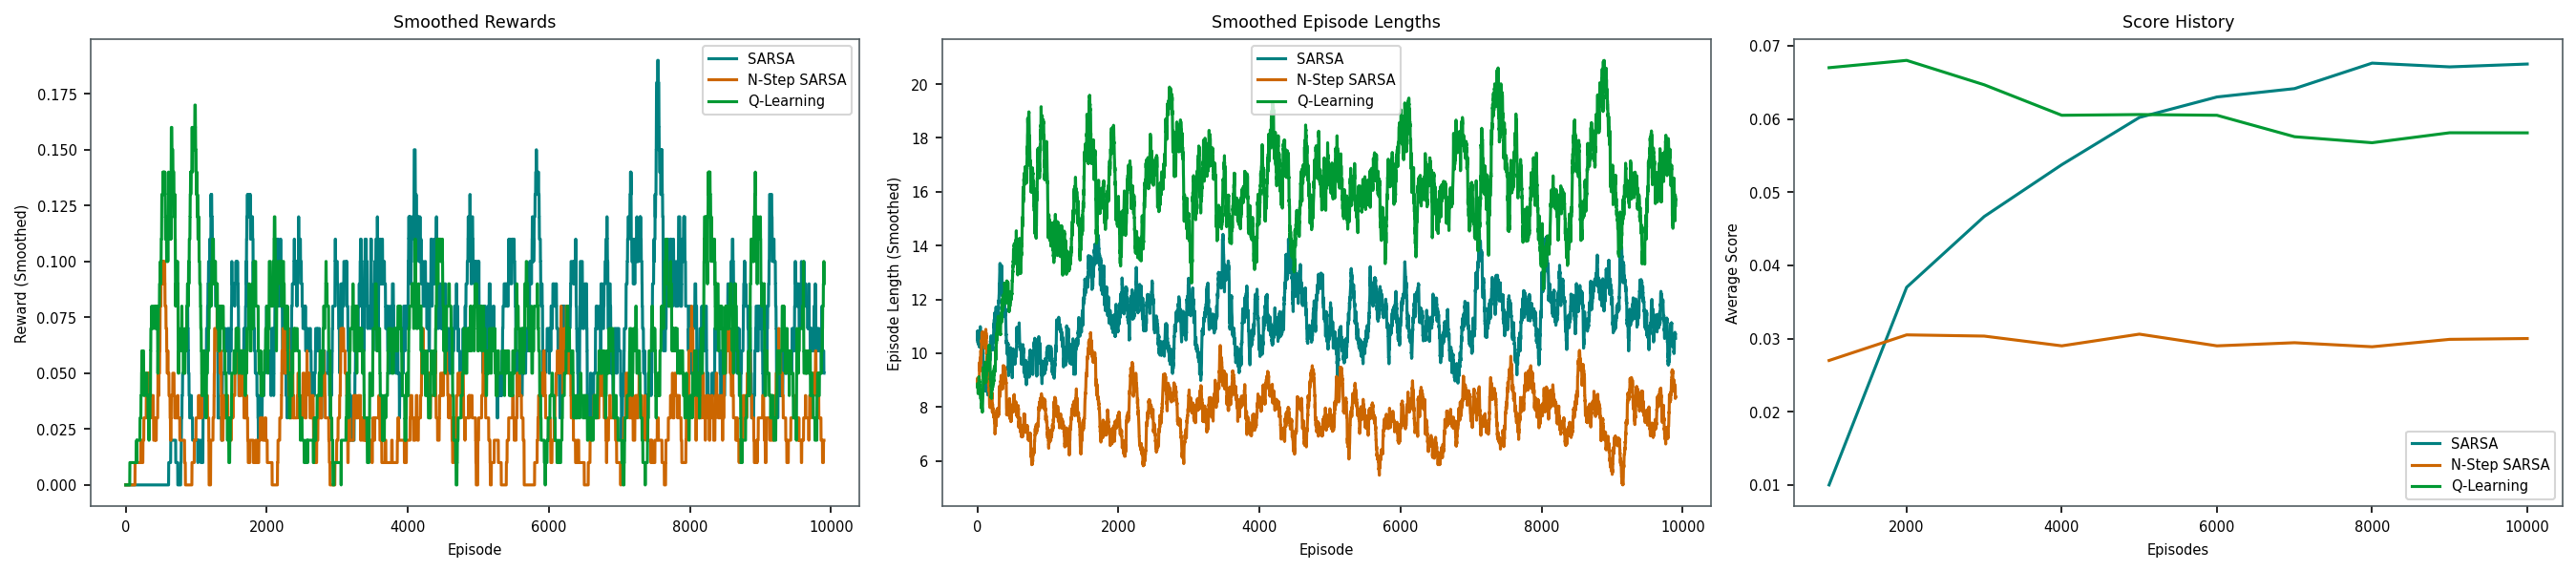

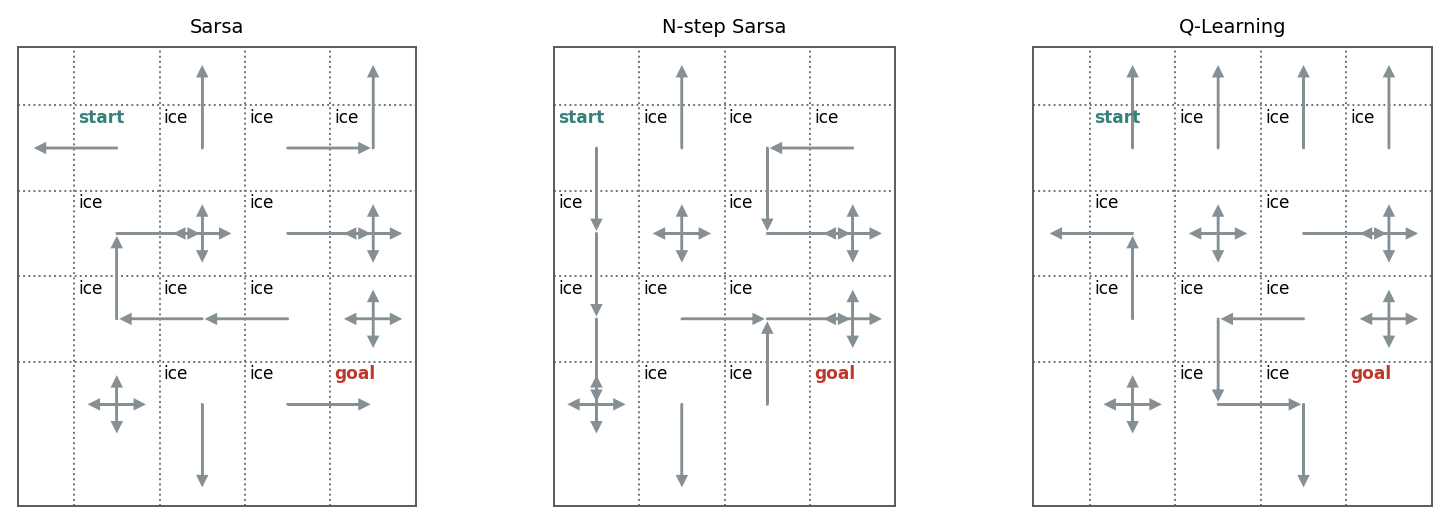

+--------------+----------------+--------------+
| SARSA        | N-Step SARSA   | Q-Learning   |
+==============+================+==============+
| [1, 0, 0, 0] | [0, 1, 0, 0]   | [0, 0, 0, 1] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 1] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 1] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 1] |
| [0, 0, 1, 0] | [0, 1, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 1, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
+--------------+----------------+--------------+


In [ ]:
run_experiment(name)

### FrozenLake8x8-v1

In [21]:
name = 'FrozenLake8x8-v1'

FrozenLake8x8-v1, Slippery=False, γ=0.9, num_episodes=100000, α=0.8:


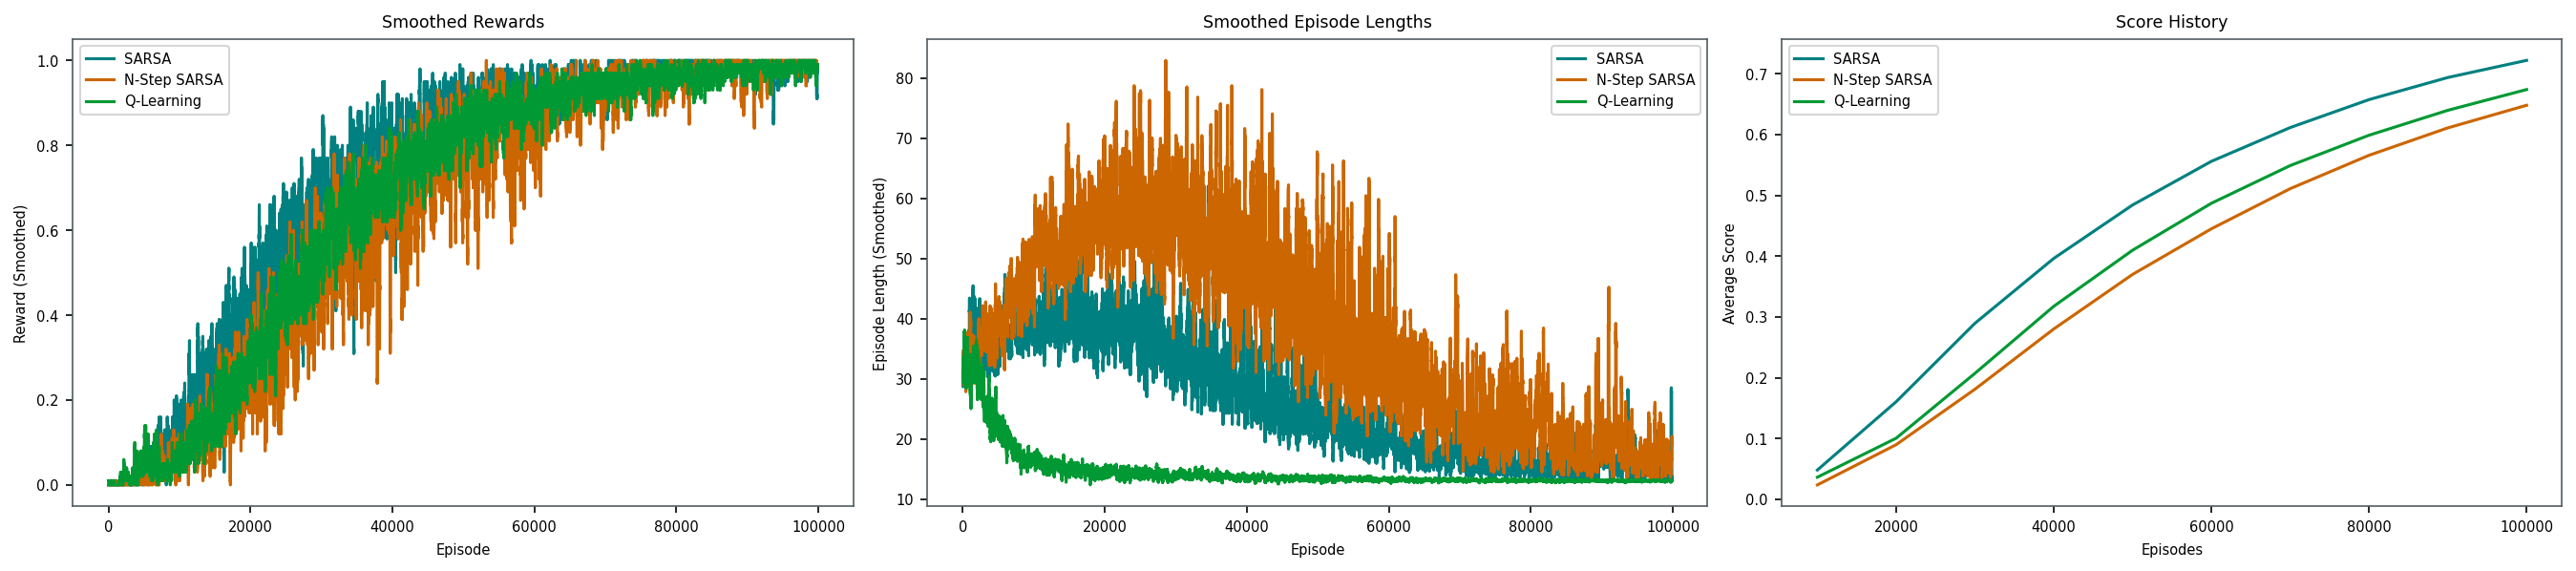

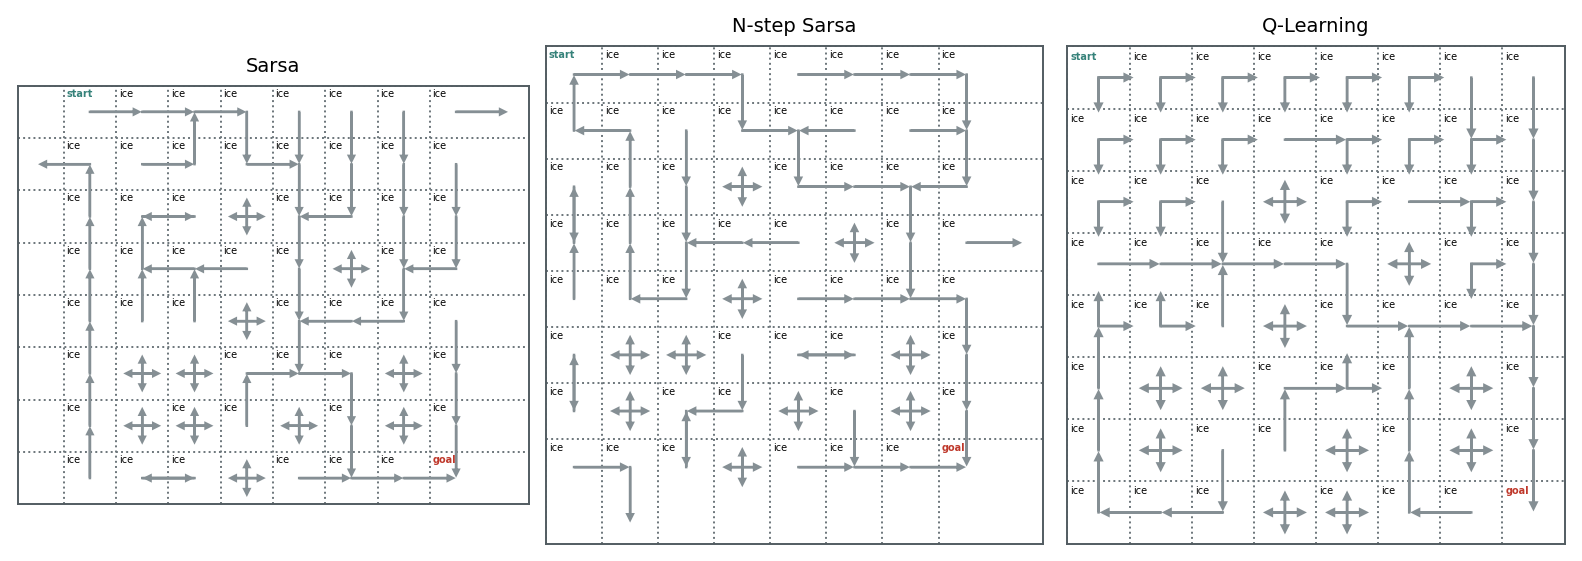

+--------------+----------------+--------------+
| SARSA        | N-Step SARSA   | Q-Learning   |
+==============+================+==============+
| [0, 0, 1, 0] | [0, 0, 1, 0]   | [0, 1, 0, 0] |
| [0, 0, 1, 0] | [0, 0, 1, 0]   | [0, 0, 0, 0] |
| [0, 0, 1, 0] | [0, 0, 1, 0]   | [0, 0, 0, 0] |
| [0, 1, 0, 0] | [0, 1, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 1, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 1, 0] | [0, 0, 1, 0]   | [0, 0, 0, 0] |
| [0, 1, 0, 0] | [0, 1, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 1, 0, 0] |
| [0, 0, 0, 0] | [0,

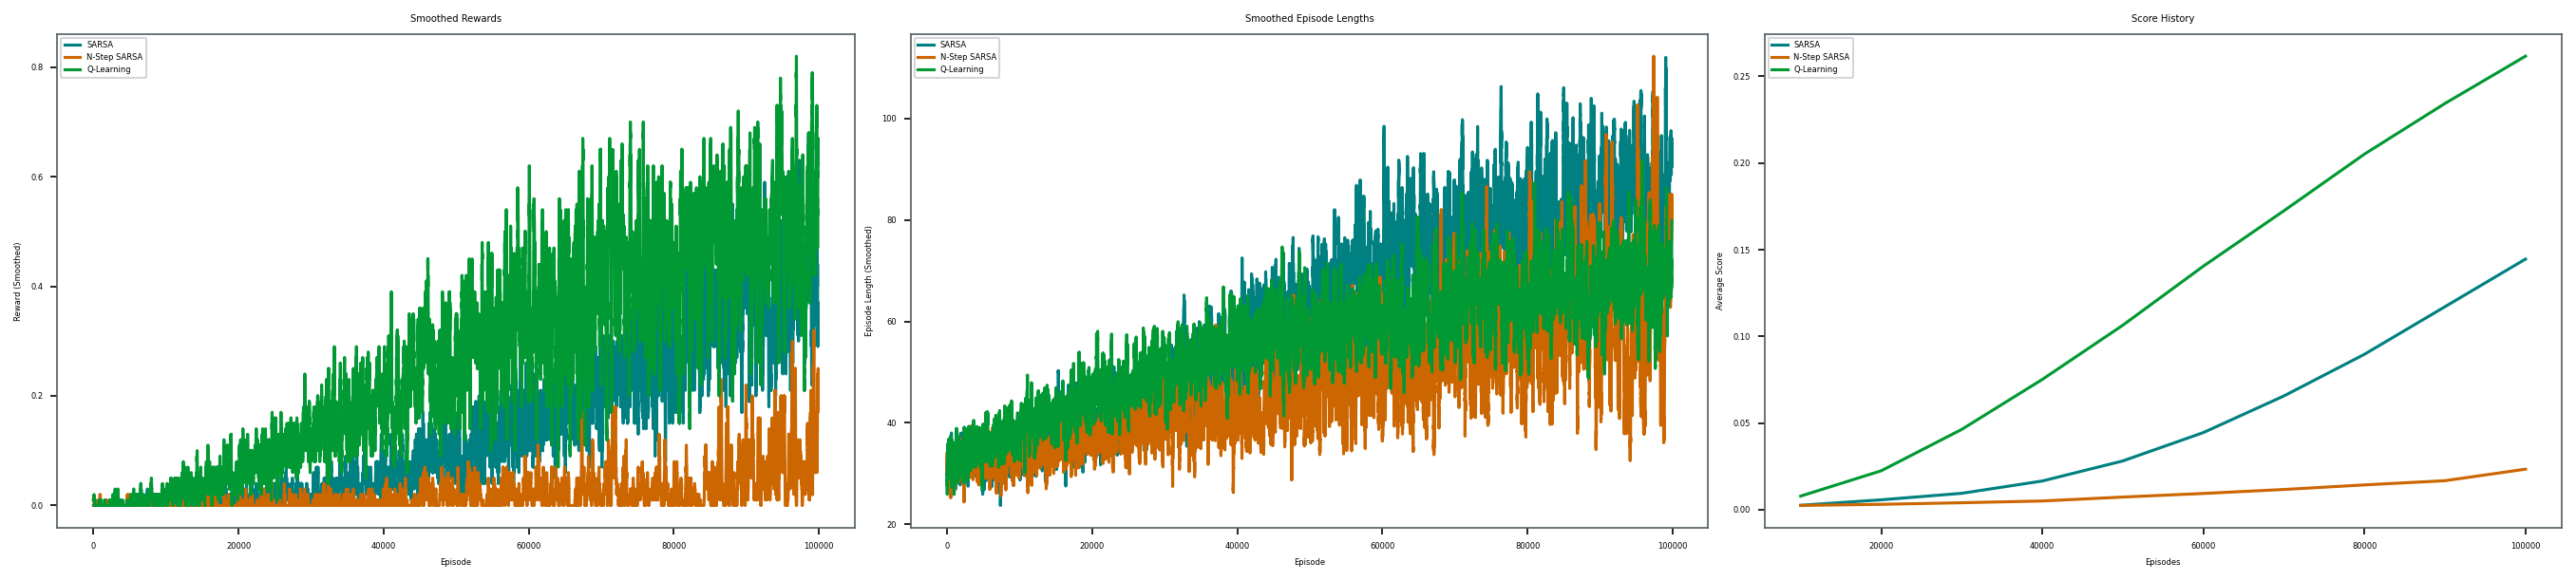

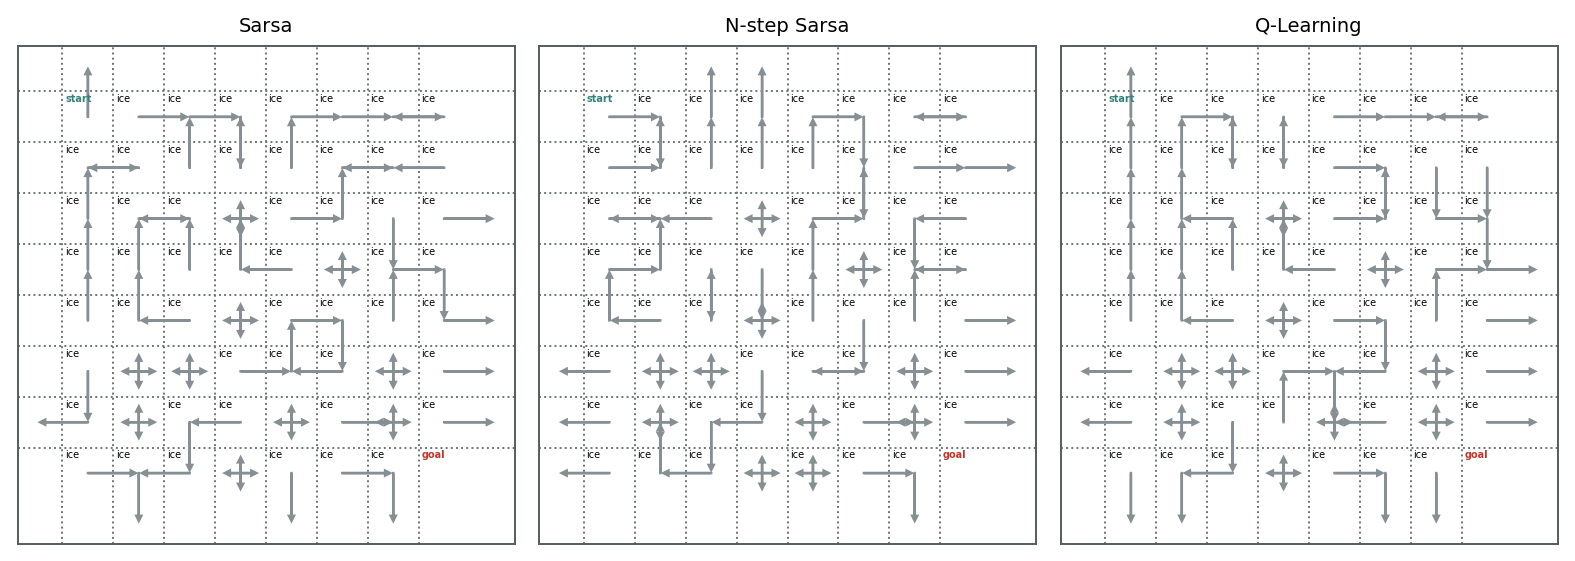

+--------------+----------------+--------------+
| SARSA        | N-Step SARSA   | Q-Learning   |
+==============+================+==============+
| [0, 0, 0, 1] | [0, 0, 1, 0]   | [0, 0, 0, 1] |
| [0, 0, 1, 0] | [0, 1, 0, 0]   | [0, 0, 1, 0] |
| [0, 0, 1, 0] | [0, 0, 0, 1]   | [0, 1, 0, 0] |
| [0, 1, 0, 0] | [0, 0, 0, 1]   | [0, 1, 0, 0] |
| [0, 0, 1, 0] | [0, 0, 1, 0]   | [0, 0, 1, 0] |
| [0, 0, 1, 0] | [0, 1, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 1, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [1, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [1, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 1] | [0, 0, 0, 0]   | [0, 0, 0, 1] |
| [0, 0, 0, 0] | [0, 0, 0, 1]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 1]   | [0, 0, 1, 0] |
| [0, 0, 1, 0] | [0, 1, 0, 0]   | [0, 1, 0, 0] |
| [1, 0, 0, 0] | [0, 0, 1, 0]   | [0, 1, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 1, 0]   | [0, 1, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0,

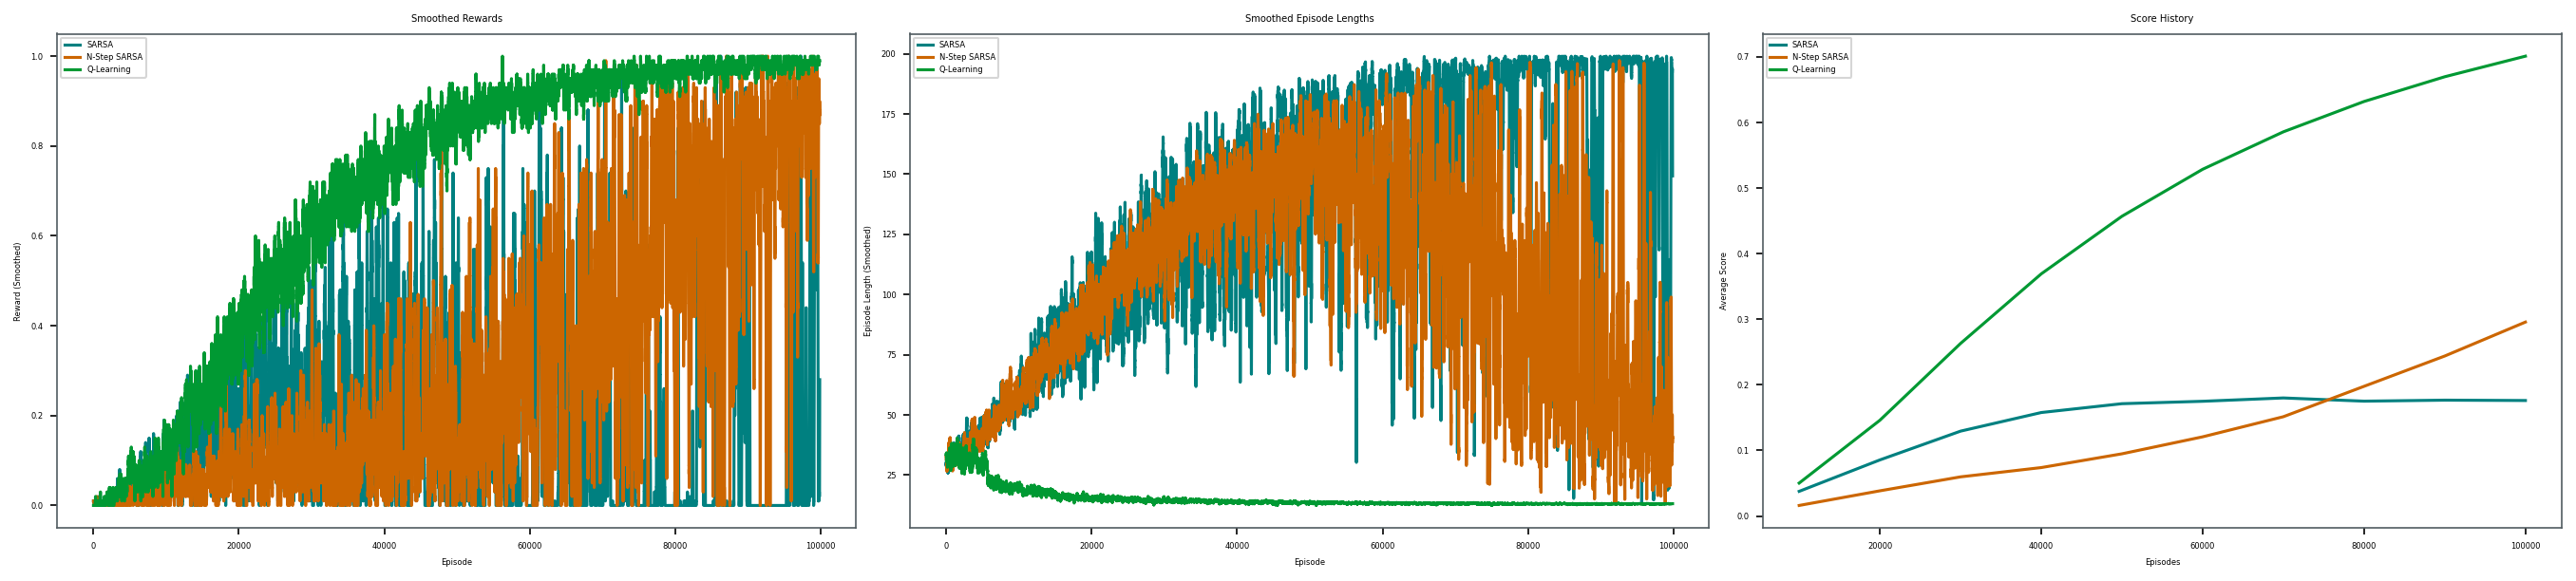

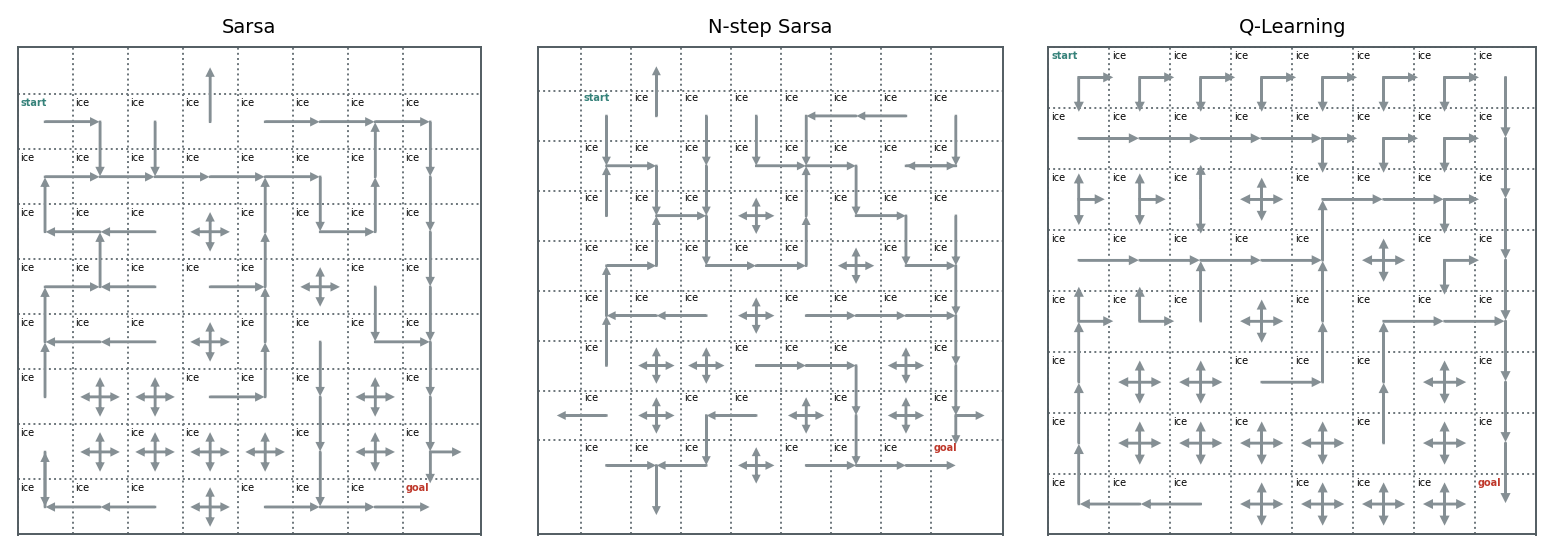

+--------------+----------------+--------------+
| SARSA        | N-Step SARSA   | Q-Learning   |
+==============+================+==============+
| [0, 0, 1, 0] | [0, 1, 0, 0]   | [0, 1, 0, 0] |
| [0, 1, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 1, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 1, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 1, 0]   | [0, 0, 1, 0] |
| [0, 0, 1, 0] | [0, 1, 0, 0]   | [0, 0, 1, 0] |
| [0, 0, 1, 0] | [0, 0, 0, 0]   | [0, 0, 1, 0] |
| [0, 0, 1, 0] | [0, 0, 0, 0]   | [0, 0, 1, 0] |
| [0, 0, 1, 0] | [0, 0, 1, 0]   | [0, 1, 0, 0] |
| [0, 1, 0, 0] | [0, 1, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 1] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 1, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [0,

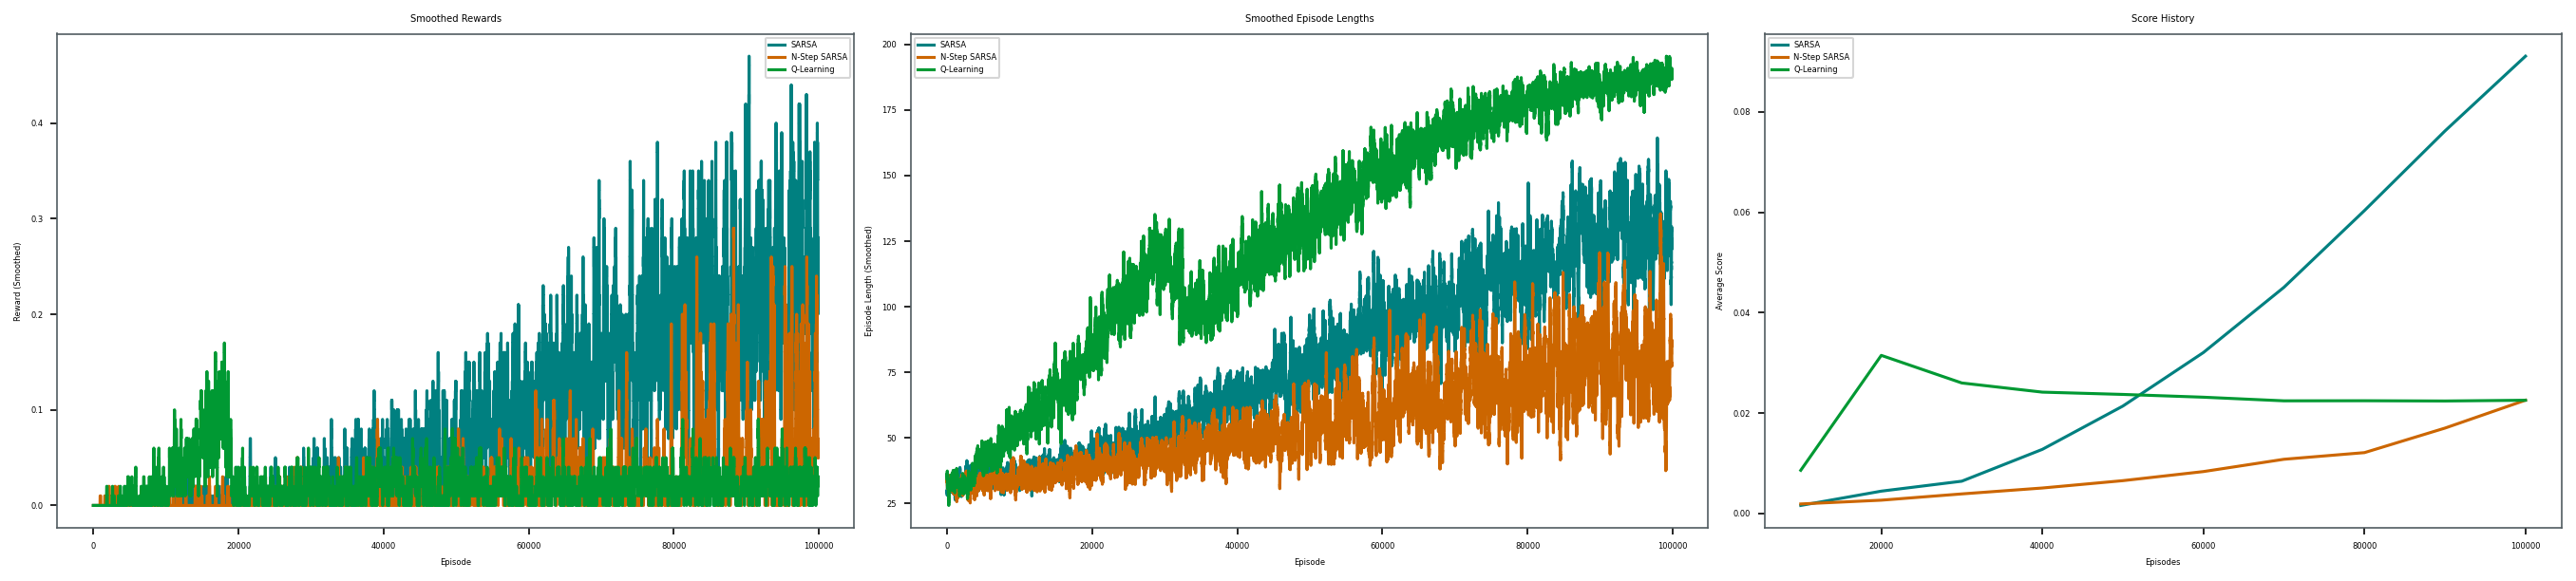

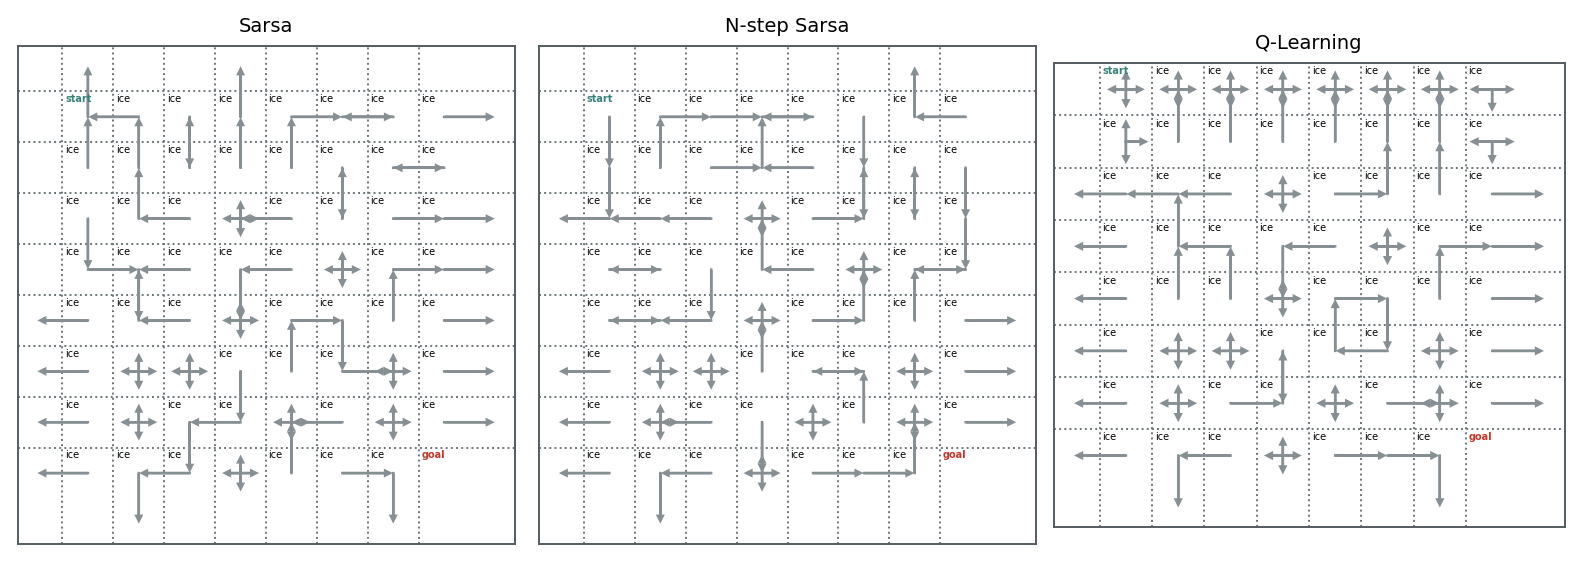

+--------------+----------------+--------------+
| SARSA        | N-Step SARSA   | Q-Learning   |
+==============+================+==============+
| [0, 0, 0, 1] | [0, 1, 0, 0]   | [1, 0, 0, 0] |
| [1, 0, 0, 0] | [0, 0, 1, 0]   | [0, 0, 0, 0] |
| [0, 1, 0, 0] | [0, 0, 1, 0]   | [1, 0, 0, 0] |
| [0, 0, 0, 1] | [0, 0, 1, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [1, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 1, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [1, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 1, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 1] | [0, 1, 0, 0]   | [0, 1, 0, 0] |
| [0, 0, 0, 1] | [0, 0, 0, 1]   | [0, 0, 0, 1] |
| [0, 0, 0, 1] | [0, 0, 1, 0]   | [0, 0, 0, 1] |
| [0, 0, 0, 1] | [0, 0, 0, 1]   | [0, 0, 0, 0] |
| [0, 0, 0, 1] | [1, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 1, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 1, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [1, 0, 0, 0] | [0, 0, 0, 0]   | [0, 0, 0, 0] |
| [0, 0, 0, 0] | [1, 0, 0, 0]   | [1, 0, 0, 0] |
| [0, 0, 0, 0] | [1,

In [22]:
run_experiment(name)

### Nhận xét kết quả thực nghiệm

Bảng nhận xét Policy

| Môi trường               | SARSA      | n-step SARSA | Q-Learning |
|---------------------------------|----------------|-------------------|----------------|
| FrozenLake(False, 0.9)      | Optimal        | Optimal           | Optimal        |
| FrozenLake(False, 1.0)      | Not Optimal    | Not Optimal       | Not Optimal    |
| FrozenLake(True, 0.9)       | Not Optimal    | Not Optimal       | Not Optimal    |
| FrozenLake(True, 1.0)       | Not Optimal    | Not Optimal       | Not Optimal    |
| FrozenLake8x8(False, 0.9)   | Not Optimal    | Not Optimal       | Optimal        |
| FrozenLake8x8(False, 1.0)   | Not Optimal    | Not Optimal       | Not Optimal    |
| FrozenLake8x8(True, 0.9)    | Not Optimal    | Not Optimal       | Not Optimal    |
| FrozenLake8x8(True, 1.0)    | Not Optimal    | Not Optimal       | Not Optimal    |

Trong cả ba thuật toán, Q-Learning có hiệu suất ổn định nhất (đặc biệt trong môi trường FrozenLake8x8(is_slippery=False, gamma=1.0) nó là thuật toán duy nhất hội tụ với epsiode=100000) và dường như trong hầu hết các môi trường thì nó cũng hội tụ nhanh hơn, tiếp theo đó là SARSA tốc độ hội tụ không nhanh bằng Q-Learning nhưng reward nhận được thì nó vẫn chỉ xếp sau Q-Learning và cuối cùng là n-step SARSA

---

1. SARSA:

- SARSA là thuật toán **on-policy**, học từ các hành động thực tế được thực hiện. Nó cập nhật Q-value dựa trên hành động tiếp theo được chọn theo chính sách hiện tại.
- Trong các thí nghiệm, SARSA thường có đường cong học tập ổn định hơn so với Q-learning.
- Thường hội tụ chậm hơn Q-learning nhưng có thể an toàn hơn trong môi trường có rủi ro cao.

---

2. n-step SARSA:
- n-step SARSA là sự kết hợp giữa SARSA và Monte Carlo. Nó cố gắng cân bằng giữa bias (như trong TD(0) hay SARSA) và variance (như trong Monte Carlo). n-step cập nhật Q-value dựa trên n bước tiếp theo, tức là xét một chuỗi các trạng thái, hành động và phần thưởng trong tương lai.
- Em đã thử chạy các giá trị n_step khác nhau và có hình ảnh đồ thị trog phần n-step Sarsa, có thể thấy với n-step càng cao thì dường như kết quả của thuật toán trả về ngày càng thấp hơn, có thể dựa trên các lý do sau:
  - Khi n tăng, thuật toán có thể thiên về phía Monte Carlo hơn, dẫn đến tăng variance. Với n lớn hơn, thuật toán xem xét nhiều bước hơn trong tương lai. Điều này có thể dẫn đến tăng phương sai trong ước tính Q-value, đặc biệt là trong môi trường có nhiều yếu tố ngẫu nhiên.
  - Trong một số môi trường, thông tin ngắn hạn (n nhỏ) có thể quan trọng hơn thông tin dài hạn (n lớn) để đưa ra quyết định tối ưu.
- Sau nhiều lần plot ra thì em quyết định chọn n-step=5 vì nó có tính ổn định cao nhất (tất nhiên là ngoại trừ n_step=1 vì nó chính là SARSA).
- 
---

3. Q-learning:

- Q-learning là thuật toán **off-policy**, học từ hành động tối ưu tiềm năng. Cập nhật Q-value dựa trên hành động tốt nhất có thể ở trạng thái tiếp theo, không phụ thuộc vào chính sách hiện tại.
- Thường hội tụ nhanh hơn SARSA nhưng có thể kém ổn định hơn trong một số môi trường (như môi trường FrozenLake8x8(is_slippery=True, gamma = 1.0) và FrozenLake4x4(is_slippery=True, gamma=1.0)).


---

Sau nhiều lần thực nghiệm em nhận thấy nếu không dùng epsilon decay với Frozenlake8x8 thì kết quả khá là thấp thậm chí là 0 (reward) sau 500000 episode, còn với FrozenLake4x4 thì nếu dùng epsilon decay như với FrozenLake8x8 thì kết quả không cao bằng dùng một constant epsilon. Có thể vì các lí do sau:

1. Độ phức tạp của môi trường
- **FrozenLake4x4**: 
  - Môi trường nhỏ và đơn giản hơn với 16 trạng thái và 4 hành động.
  - Không gian tìm kiếm tương đối nhỏ.

- **FrozenLake8x8**: 
  - Phức tạp hơn với 64 trạng thái.
  - Không gian tìm kiếm lớn hơn đáng kể.


2. Cân bằng giữa khám phá và khai thác
- **FrozenLake4x4**: 
  - Duy trì tỷ lệ khám phá không đổi (constant epsilon) có thể đủ để agent tìm ra chính sách tối ưu.
  - Môi trường nhỏ, không cần giảm dần việc khám phá.

- **FrozenLake8x8**: 
  - Sử dụng epsilon decay giúp agent chuyển dần từ khám phá sang khai thác.
  - Ban đầu cần khám phá nhiều để hiểu môi trường phức tạp, sau đó tập trung khai thác kiến thức đã học.


3. Vấn đề về tổng quát hóa
- **FrozenLake4x4**: 
  - Duy trì mức khám phá không đổi có thể giúp agent tránh "over-fitting" vào một số đường đi cụ thể.

- **FrozenLake8x8**: 
  - Epsilon decay giúp agent dần tập trung vào các hành động tốt nhất đã học, cải thiện khả năng tổng quát hóa trong không gian lớn hơn.

4. Độ nhạy với nhiễu
- **FrozenLake4x4**: 
  - Ít nhạy cảm với nhiễu do kích thước nhỏ.
  - Constant epsilon có thể đủ.

- **FrozenLake8x8**: 
  - Phức tạp hơn và nhạy cảm hơn với nhiễu.
  - Epsilon decay giúp giảm dần ảnh hưởng của nhiễu khi agent học được nhiều hơn.


Kết luận
- **FrozenLake4x4**: Constant epsilon đủ để đạt kết quả tốt do môi trường đơn giản.
- **FrozenLake8x8**: Sử dụng epsilon decay là cần thiết để cân bằng giữa khám phá và khai thác trong môi trường phức tạp hơn, giúp agent học hiệu quả hơn và đạt kết quả tốt sau nhiều episode.


---
Do việc thử nghiệm rất nhiều nhưng dường như vẫn chưa đủ để các thuật toán hội tụ ở hầu hết các môi trường. Cần thử thêm các giá trị alpha và nâng số episode lên.